In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

In [2]:
preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
print(preDouble)

\\iobsdc01\SharedDocs\SEER_MEDICARE\SEER_MEDICARE_STAGING


In [3]:
import pickle
fileObject = open('pure_control_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices = list(b)


In [4]:
import pickle
fileObject = open('pure_treatment_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices = list(b)


In [5]:
df = pd.read_pickle('dfpedsfFirsts.pickle')


In [6]:
dg = pd.read_pickle('pure_goodindices_medpar.pickle')

In [7]:
d_t_c = dict(zip(treatmentindices, controlindices))
d_c_t = dict(zip(controlindices, treatmentindices))

In [8]:
dgtreatment = dg[dg.patient_id.isin(treatmentindices)].copy()

dgcontrol = dg[dg.patient_id.isin(controlindices)].copy()

In [9]:

df = df.set_index('patient_id',drop=False)

In [10]:
goodindices = controlindices + treatmentindices
print(len(goodindices),len(controlindices),len(treatmentindices))

1662 831 831


In [11]:
df_all_good_indices = df.loc[goodindices].copy()

In [12]:
del df

In [13]:

monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}


df_all_good_indices['month1'] = df_all_good_indices['modx1'].replace(monthdict)

# <font color="#E56717">We need to only keep claims for which the date of admission is later in time than the cancer diagnosis date</font>

## Let's limit it just to prostate

In [14]:
#bad_month_indices_filter = df_all_good_indices['month1'].isnull()
prostate_filter = df_all_good_indices['site1'].str.contains('prostate',case=False,na=False)
to_drop = list(df_all_good_indices[~prostate_filter].site1.index)
print(to_drop)

['4482160083', '2215176050', '8859072472', '2310153070', '8802026371', '8757024520', '8831097343', '8878004314', '8827010107', '4408106073', '8797097489', '8835013250', '4339013024', '4304141320', '4326238080', '4269060013', '8848090384', '4268053014', '8797035478', '8841081424', '8868081313', '4339033024', '4222034004', '8735038409', '8716025459', '4462162024', '8821066343', '8858012304', '8845030491', '8841000365', '8888027441', '4313295000', '8825058106', '8888086461', '4473112043', '8714009560', '8870085471', '8819038335', '8885077334', '8865081345', '8815026310', '8889005430', '4454195034', '4247072024', '8851092441', '8897051314', '4295048060', '8852000315', '8875067360', '4315229060']


In [15]:
drop_set = set(to_drop)
t_set = set(d_t_c.keys())

lose_set = t_set.intersection(drop_set)
print(len(lose_set))


25


In [16]:
for i in list(lose_set):
    del d_t_c[i]

In [17]:
goodtreatmentindices = d_t_c.keys()
goodcontrolindices = d_t_c.values()
print(len(goodtreatmentindices), len(goodcontrolindices))

806 806


# Just including the prostate cancer patients now

In [18]:

df_all_good_indices = df_all_good_indices.loc[list(goodcontrolindices) + list(goodtreatmentindices)]

In [20]:
df_all_good_indices.month1.value_counts()

08    152
02    150
06    146
03    146
01    140
04    136
10    136
05    134
07    134
11    130
09    106
12     96
Name: month1, dtype: int64

In [21]:
df_all_good_indices.month1.iloc[0]

'05'

In [22]:
df_all_good_indices['newmonth1'] = df_all_good_indices.month1.fillna('01').copy()

In [23]:

df_all_good_indices['yrdx_plus_modx'] = df_all_good_indices.yrdx1.astype('str') + df_all_good_indices.newmonth1.astype('str')


df_all_good_indices['yrdx_plus_modx'] = pd.to_datetime(df_all_good_indices['yrdx_plus_modx'], 
                                                      format='%Y%m')

In [46]:
dg = dg.set_index('patient_id',drop=False)

In [50]:
dgtreatment = dg[dg.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dgcontrol = dg[dg.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

In [51]:
dgtreatment.shape

(1037, 171)

In [52]:
dgcontrol.shape

(1628, 171)

In [53]:
dg.shape

(2917, 171)

In [54]:
dgtreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgtreatment['site1'] = df_all_good_indices['site1']

In [55]:
dgtreatment.shape

(1037, 173)

In [56]:
dgcontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgcontrol['site1'] = df_all_good_indices['site1']

In [57]:
dgcontrol.shape

(1628, 173)

In [58]:
dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date.astype('str').str.replace('\.0','')
dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date_new.str.rjust(8,'0')

In [59]:
dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date.astype('str').str.replace('\.0','')
dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date_new.str.rjust(8,'0')

In [60]:
dgtreatment['medpar_admission_date_new'] = pd.to_datetime(dgtreatment['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()

In [61]:
dgcontrol['medpar_admission_date_new'] = pd.to_datetime(dgcontrol['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()

In [62]:
df_all_good_indices.shape

(1612, 499)

In [63]:
dgtreatment.head()

,registry,patient_id,age,stdstate,std_cnty,admday,dschgsta,ghopd,ppsind,provcode,...,outclrcde,primpayr,esrdcond,admsrce,admtype,admdxcde,deathadm,yrdx_plus_modx,site1,medpar_admission_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
8876036350,88,8876036350,77,5,430,2,A,NaN,2,NaN,...,0,NaN,0,7,2,6824,0,2006-05-01,Prostate gland,2006-04-23
8860084330,88,8860084330,70,5,430,5,A,NaN,2,NaN,...,0,NaN,0,1,3,4139,0,2006-01-01,Prostate gland,2006-12-06
8881015430,88,8881015430,75,5,460,2,A,NaN,2,NaN,...,0,NaN,0,7,1,35800,0,2010-02-01,Prostate gland,2006-10-08
8881015430,88,8881015430,75,5,460,5,A,NaN,2,NaN,...,2,NaN,0,7,1,51881,0,2010-02-01,Prostate gland,2006-10-25
8881015430,88,8881015430,75,5,460,7,A,NaN,2,NaN,...,0,NaN,0,1,2,35801,0,2010-02-01,Prostate gland,2006-12-15


In [64]:
dgcontrol.head()

,registry,patient_id,age,stdstate,std_cnty,admday,dschgsta,ghopd,ppsind,provcode,...,outclrcde,primpayr,esrdcond,admsrce,admtype,admdxcde,deathadm,yrdx_plus_modx,site1,medpar_admission_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
8844065341,88,8844065341,67,5,650,7,A,NaN,2,NaN,...,0,NaN,0,7,2,85220,0,2007-02-01,Prostate gland,2006-11-03
8842059335,88,8842059335,74,5,640,6,A,NaN,2,NaN,...,0,NaN,0,1,2,78609,0,2009-08-01,Prostate gland,2006-06-22
8890073491,88,8890073491,71,5,200,5,A,NaN,2,NaN,...,0,NaN,0,7,1,7802,0,2011-04-01,Prostate gland,2006-01-04
4422191074,44,4422191074,65,31,260,2,A,NaN,2,NaN,...,0,NaN,0,7,1,4280,1200,2008-05-01,Prostate gland,2006-08-13
8890067390,88,8890067390,75,5,400,3,A,NaN,2,NaN,...,0,NaN,0,7,2,2989,0,2006-05-01,Prostate gland,2006-11-06


# <font color="#E56717">Hospital Data</font>

* <span style="font-size:1.5em;">MedPAR: Medicare Provider and Review</span>
* <span style="font-size:1.5em;">One record per stay</span>
* <span style="font-size:1.5em;">Key elements: admission and discharge diagnoses and dates, procedures and procedure dates, revenue center codes for ER,etc.</span>
* <span style="font-size:1.5em;">Reports facility charges only</span>
* <span style="font-size:1.5em;">Paid by DRG (diagnostic review group) which is based on diagnoses and procedures</span>


# <font color="#E56717">Cost-related variables</font>

* <span style="font-size:1.5em;">Charges (what the hospital asked to be paid</span>
* <span style="font-size:1.5em;">What the hospital was paid: amount reimbursed PLUS bill total per diem</span>
* <span style="font-size:1.5em;">Deductibles</span>
* <span style="font-size:1.5em;">Primary Payer amount</span>

<span style="font-size:1.5em;">Medicare determines what the provider is allowed to charge for a service ('allowed charges'). Payment of the allowed charges come from two sources:</span>

* <span style="font-size:1.5em;">Medicare</span>
* <span style="font-size:1.5em;">Beneficiary: Co-payments, coinsurance, and deductibles (may be paid by coinsurance such as Medigap)</span>

* <span style="font-size:1.5em;">Hospitals have per-stay deductibles and co-payments</span>


# <font color="#E56717">Trying to figure out MedPAR payments</font>

* <span style="font-size:1.5em;">Total payments from Medicare are calculated as reimbursement amount PLUS total pass through amount</span>
* <span style="font-size:1.5em;">Primary payer amount is the amount paid by another insurance (before Medicare)</span>
* <span style="font-size:1.5em;">Total payments: need to add together Medicare payments, primary payer amount and copayment/deductible</span>


# <font color="#E56717">Use these fields in the MedPAR file</font>

* <span style="font-size:1.5em;">COINAMT - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for part A coinsurance for the stay</span> 
* <span style="font-size:1.5em;">INPATDED - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for inpatient deductible for the stay</span>
* <span style="font-size:1.5em;">BLOODDED - The amounf of money (rounded to whole dollars) identified as the beneficiary's liability for the blood deductible for the stay</span>
* <span style="font-size:1.5em;">PRIPYAMT - The amount of payment (rounded to whole dollars) made on behalf of the beneficiary by a primary payer other than Medicare, which has been applied to the covered Medicare charges for the stay</span>
* <span style="font-size:1.5em;">DISHRAMT - The amount paid over the DRG amount (rounded to whole dollars) for the disproportionate share hospital for the stay</span>
* <span style="font-size:1.5em;">INDMEDED - The amount of additional payment (rounded to whole dollars) made to teaching hospitals for IME for the stay</span>
* <span style="font-size:1.5em;">DRGPRICE - The amount (called the DRG price) that would have been paid if no deductibles, coinsurance, primary payers, or outliers were involved (rounded to whole dollars)</span>
* <span style="font-size:1.5em;">PASSTHRU - The total of all claim pass through amounts (rounded to whole dollars) for the stay.</span>
* <span style="font-size:1.5em;">REIMBAMT - Amount of payment made from the Medicare trust fund for the services covered by the claim record</span>

In [66]:
list(dgcontrol.columns)

['registry',
 'patient_id',
 'age',
 'stdstate',
 'std_cnty',
 'admday',
 'dschgsta',
 'ghopd',
 'ppsind',
 'provcode',
 'snfind',
 'numbills',
 'latest_claim_accretion_date',
 'benefit_exhausted_date',
 'qualification_from_date',
 'qualification_through_date',
 'medpar_admission_date',
 'medpar_discharge_date',
 'bene_death_date',
 'cvr_through_date',
 'himasind',
 'los',
 'outlrday',
 'cvrddays',
 'coindays',
 'lifresdy',
 'coinamt',
 'inpatded',
 'bloodded',
 'pripyamt',
 'outlramt',
 'dishramt',
 'indmeded',
 'drgprice',
 'passthru',
 'low_pamt',
 'totchrgs',
 'cvrdchrg',
 'reimbamt',
 'totacchr',
 'totdpchr',
 'incrdays',
 'crcrdays',
 'incrchrg',
 'crcrchrg',
 'phrmchrg',
 'phytchrg',
 'ocptchrg',
 'spptchrg',
 'inhtchrg',
 'blddchrg',
 'bladchrg',
 'oprtchrg',
 'lithchrg',
 'cardchrg',
 'anstchrg',
 'labrchrg',
 'radichrg',
 'opsrchrg',
 'mrichrg',
 'emrmchrg',
 'amblchrg',
 'proffees',
 'oraqchrg',
 'esrdchrg',
 'clvtchrg',
 'increind',
 'crcreind',
 'phrmyind',
 'trnspind',
 '

In [73]:
dgcontrol['total_amt'] = dgcontrol['coinamt'] + dgcontrol['inpatded'] + \
dgcontrol['bloodded'] + dgcontrol['pripyamt'] +  \
dgcontrol['indmeded'] + dgcontrol['passthru'] + \
dgcontrol['reimbamt']

In [74]:
dgtreatment['total_amt'] = dgtreatment['coinamt'] + dgtreatment['inpatded'] + \
dgtreatment['bloodded'] + dgtreatment['pripyamt'] + \
dgtreatment['indmeded'] + dgtreatment['passthru'] + \
dgtreatment['reimbamt']

In [75]:
goodcols = ['medpar_admission_date_new','yrdx_plus_modx','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [76]:
dgcontrol[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,
8844065341,2006-11-03,2007-02-01,13309,0,952,0,0,0,0,12357
8842059335,2006-06-22,2009-08-01,5920,0,952,0,0,0,0,4968
8890073491,2006-01-04,2011-04-01,6248,0,952,0,0,187,0,5109
4422191074,2006-08-13,2008-05-01,7616,0,952,0,0,388,0,6276
8890067390,2006-11-06,2006-05-01,4936,0,952,0,0,0,0,3984


In [77]:
dgtreatment[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,
8876036350,2006-04-23,2006-05-01,3324,0,952,0,0,0,0,2372
8860084330,2006-12-06,2006-01-01,13399,0,952,0,0,0,0,12447
8881015430,2006-10-08,2010-02-01,9823,0,952,0,0,1028,0,7843
8881015430,2006-10-25,2010-02-01,47396,0,0,0,0,1526,0,45870
8881015430,2006-12-15,2010-02-01,9823,0,0,0,0,1028,0,8795


# <font color="#E56717">Now restrict to those claims where medpar_admission_date_new is later in time than yrdx_plus_modx</font>

In [82]:
dgtreatment['time_delta'] = dgtreatment['medpar_admission_date_new'] - dgtreatment['yrdx_plus_modx']

dgcontrol['time_delta'] = dgcontrol['medpar_admission_date_new'] - dgcontrol['yrdx_plus_modx']


In [83]:
def make_days(i):
    return i.days

In [85]:
dgtreatment['delta_days'] = dgtreatment['time_delta'].apply(make_days)
dgcontrol['delta_days'] = dgcontrol['time_delta'].apply(make_days)

In [86]:
goodcols = ['medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [87]:
dgtreatment[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8876036350,2006-04-23,2006-05-01,-8 days,-8,3324,0,952,0,0,0,0,2372
8860084330,2006-12-06,2006-01-01,339 days,339,13399,0,952,0,0,0,0,12447
8881015430,2006-10-08,2010-02-01,-1212 days,-1212,9823,0,952,0,0,1028,0,7843
8881015430,2006-10-25,2010-02-01,-1195 days,-1195,47396,0,0,0,0,1526,0,45870
8881015430,2006-12-15,2010-02-01,-1144 days,-1144,9823,0,0,0,0,1028,0,8795


In [88]:
dgcontrol[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8844065341,2006-11-03,2007-02-01,-90 days,-90,13309,0,952,0,0,0,0,12357
8842059335,2006-06-22,2009-08-01,-1136 days,-1136,5920,0,952,0,0,0,0,4968
8890073491,2006-01-04,2011-04-01,-1913 days,-1913,6248,0,952,0,0,187,0,5109
4422191074,2006-08-13,2008-05-01,-627 days,-627,7616,0,952,0,0,388,0,6276
8890067390,2006-11-06,2006-05-01,189 days,189,4936,0,952,0,0,0,0,3984


In [90]:
good_claims_filter_treatment = dgtreatment.delta_days > 0
good_claims_filter_control = dgcontrol.delta_days > 0

In [92]:
dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()

In [93]:
dgtreatmentgoodclaims[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8860084330,2006-12-06,2006-01-01,339 days,339,13399,0,952,0,0,0,0,12447
8899006269,2006-02-18,2006-01-01,48 days,48,5432,0,952,0,0,0,0,4480
8884030330,2006-09-25,2006-04-01,177 days,177,5851,0,952,0,0,635,0,4264
8827052320,2006-10-24,2006-04-01,206 days,206,15408,0,952,0,0,0,0,14456
8827052320,2006-10-22,2006-04-01,204 days,204,3554,0,0,0,0,0,0,3554


In [94]:
dgcontrolgoodclaims[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8890067390,2006-11-06,2006-05-01,189 days,189,4936,0,952,0,0,0,0,3984
8806031320,2006-06-08,2006-02-01,127 days,127,34370,0,952,0,0,6850,0,26568
8806031320,2006-06-27,2006-02-01,146 days,146,34739,0,0,0,0,3880,0,30859
8865083320,2006-08-14,2006-01-01,225 days,225,10682,0,952,0,0,0,0,9730
8809018330,2006-02-07,2006-02-01,6 days,6,13375,0,0,0,0,0,0,13375


In [95]:
dgtreatment['srvm1'] = df_all_good_indices['srvm1']

In [96]:
dgcontrol['srvm1'] = df_all_good_indices['srvm1']

In [97]:
dgtreatment.shape

(1037, 178)

In [98]:
def make_months(i):
    return int(i.days/30)

In [99]:
dgtreatment['delta_months'] = dgtreatment['time_delta'].apply(make_months)
dgcontrol['delta_months'] = dgcontrol['time_delta'].apply(make_months)

In [112]:
goodcols = ['patient_id','medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days',
            'delta_months','srvm1','total_amt','los',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [113]:
dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()

In [114]:
dgtreatmentgoodclaims[goodcols].head()

,patient_id,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,delta_months,srvm1,total_amt,los,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,,,,,
8860084330,8860084330,2006-12-06,2006-01-01,339 days,339,11,77,13399,1,0,952,0,0,0,0,12447
8899006269,8899006269,2006-02-18,2006-01-01,48 days,48,1,74,5432,1,0,952,0,0,0,0,4480
8884030330,8884030330,2006-09-25,2006-04-01,177 days,177,5,80,5851,2,0,952,0,0,635,0,4264
8827052320,8827052320,2006-10-24,2006-04-01,206 days,206,6,78,15408,2,0,952,0,0,0,0,14456
8827052320,8827052320,2006-10-22,2006-04-01,204 days,204,6,78,3554,1,0,0,0,0,0,0,3554


In [115]:
a = dgtreatmentgoodclaims.delta_months - dgtreatmentgoodclaims.srvm1
a.describe()

count    815.000000
mean     -16.807362
std       21.508491
min      -82.000000
25%      -31.000000
50%      -13.000000
75%        0.000000
max       18.000000
dtype: float64

# <font color="#E56717">In the plot below, the 20% of patients with claims at a date further in the future than the followup time survival months in the SEER piece must be the 2011 DX patients and their 2011, 2012, and 2013 claims. Makes sense; so let's just look at all claims after the DX</font>

# 80% of the claims are prior to the listed the dx date plus survival months

In order to capture the costs of those patients who were diagnosed write at the end of 2011 (and so have low, censored values of srvm1), we need to just include all claims after the dx date

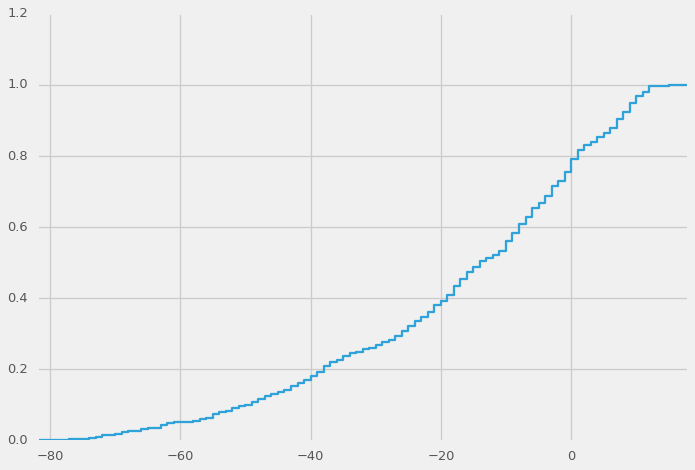

In [116]:
a.value_counts(normalize=True).sort_index().cumsum().plot(drawstyle='steps')

# <font color="#E56717">Not all patients are in the MEdpar file, but all are in the NCH file concatenated with the OUTSAF file; we can perform a paired test to see if there are statistically significant differences after getting the analog of total_amt for those two files and concatenating with this medpar result</font>


# For now, let's just look at the CDFs of the tot_amt grouped for each patient (a patient may have more than one stay). Do the same for 'los': length of stay in days

In [117]:
dgmedpartreatmentgroup = dgtreatmentgoodclaims.groupby('patient_id')

In [118]:
dgmedparcontrolgroup = dgcontrolgoodclaims.groupby('patient_id')

In [126]:
treatmentmedparagg = dgmedpartreatmentgroup[['total_amt','los']].agg(np.sum)

In [127]:
controlmedparagg = dgmedparcontrolgroup[['total_amt','los']].agg(np.sum)

In [128]:
treatmentmedparagg.head()

,total_amt,los
patient_id,,
0231464080,5736,2
0247481030,34517,10
0274414060,28452,12
2136138000,0,1
2225043505,56790,39


In [129]:
treatmentmedparagg.shape

(327, 2)

In [130]:
controlmedparagg.shape

(451, 2)

In [131]:
treatmentmedparagg.describe()

,total_amt,los
count,327.000000,327.000000
mean,36400.639144,15.345566
std,47866.040142,27.008403
min,0.000000,1.000000
25%,9163.000000,2.000000
50%,20634.000000,5.000000
75%,44371.000000,15.500000
max,480172.000000,254.000000


In [133]:
controlmedparagg.describe() # a big outlier    lets look at the CDFS

,total_amt,los
count,4.510000e+02,451.000000
mean,4.071565e+04,18.611973
std,9.765959e+04,40.945033
min,0.000000e+00,1.000000
25%,9.031500e+03,3.000000
50%,2.049000e+04,6.000000
75%,4.363300e+04,18.000000
max,1.853452e+06,468.000000


(0, 200000)

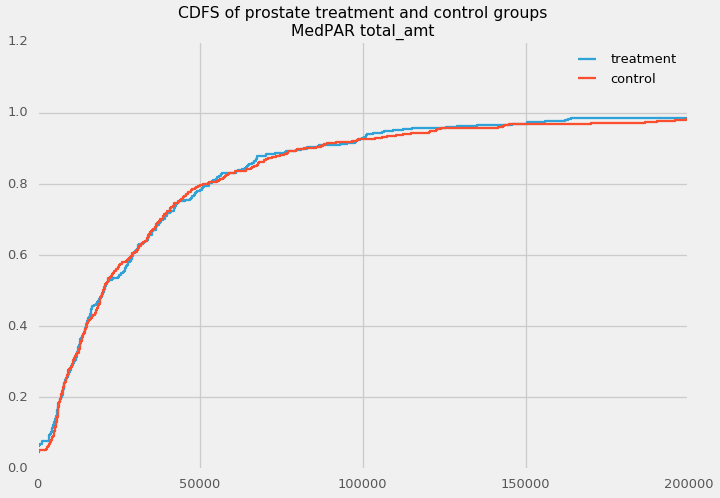

In [136]:
at = treatmentmedparagg.total_amt.value_counts(normalize=True).sort_index().cumsum()
ac = controlmedparagg.total_amt.value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control')
plt.legend()
plt.title('CDFS of prostate treatment and control groups\nMedPAR total_amt')
plt.xlim(0,200000)

(0, 300)

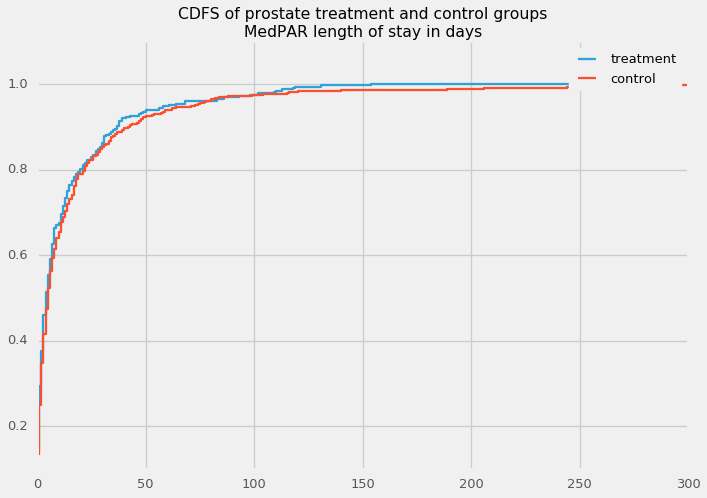

In [138]:
at = treatmentmedparagg.los.value_counts(normalize=True).sort_index().cumsum()
ac = controlmedparagg.los.value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control')
plt.legend()
plt.title('CDFS of prostate treatment and control groups\nMedPAR length of stay in days')
plt.xlim(0,300)

In [139]:
from scipy import stats

In [140]:
stats.ks_2samp(treatmentmedparagg.los.as_matrix(),
              controlmedparagg.los.as_matrix())

Ks_2sampResult(statistic=0.049417875329712535, pvalue=0.7332262629635794)

In [141]:
stats.ks_2samp(treatmentmedparagg.total_amt.as_matrix(),
              controlmedparagg.total_amt.as_matrix())

Ks_2sampResult(statistic=0.033632363012537539, pvalue=0.98110084171196255)

# <font color="#E56717">Outpatient Claims from Facilities</font>

* <span style="font-size:1.5em;">Care that is provided by hospitals on an outpatient basis is found in the outpatient file</span>
* <span style="font-size:1.5em;">The billing form (UB-92) used for inpatient hospitalizations is also used for hospital outpatient, skilled nursing facility, home health and hospice claims</span>
* <span style="font-size:1.5em;">Examples of such are include:</span>
    * <span style="font-size:1.5em;">Day surgery</span>
    * <span style="font-size:1.5em;">Therapeutic radiology</span>
    * <span style="font-size:1.5em;">ER not resulting in an inpatient admission</span>

# <font color="#E56717">Structure of Outpatient Data</font>

* <span style="font-size:1.5em;">The outpatient data are structured differently than the MedPAR even though they are both derived from facility claims. In the outpatient, there is a summary record with revenue center code of 0001 for each bill.</span>
* <span style="font-size:1.5em;">There is also one record for each recenue center code listed on the claim (and associated detail)</span>
    * <span style="font-size:1.5em;">these are not rolled up or combined in any way;</span>
    * <span style="font-size:1.5em;">revenue center codes can repeat on a single claim</span>
* <span style="font-size:1.5em;">All records from a partciular claim include the same non-revenue center-level detail</span>
    * <span style="font-size:1.5em;">Therefore, a bill with one revenue center code would have two records in a file - a summary and the one for the single revenue center</span>
    * <span style="font-size:1.5em;">a bill with 10 revenue center codes would have 11 records in the file - the summary and the 10 specific codes. The basic information about claim from - claim through, total payments, etc. would be repeated 11 times</span>

# <font color="#E56717">Variables that researchers often use in the Hospital Outpatient file</font>

* <span style="font-size:1.5em;">Provder information</span>
    * <span style="font-size:1.5em;">Hospital number (encrypted) - first 2 digits are the state where the hospital is located</span>
    * <span style="font-size:1.5em;">Identify of physican providing care (encrypted)</span>
* <span style="font-size:1.5em;">Date of service started and stopped - this can be a single day or a span of days</span>
* <span style="font-size:1.5em;">Diagnosis codes</span>
* <span style="font-size:1.5em;">Procedure codes:</span>
    * <span style="font-size:1.5em;">HCPCS codes for the services provided linked to a revenue center code</span>
    * <span style="font-size:1.5em;">ICD-9 procedure codes - used previously, phased out, not used for current billing</span>
* <span style="font-size:1.5em;">Total charges and reimbursement</span>

# <font color="#E56717">Payments in the Outpatient file</font>

* <span style="font-size:1.5em;">Payments in the Outpatient file are based on service, referred to as "Revenue Centers." This is similar to line items</span>
* <span style="font-size:1.5em;">Each line in the Outpatient file is a "Revenue Center" within a claim. Each claim contains at least two records, one of which is a summary record. The Summary record contains Revenue Center = 0001</span>
* <span style="font-size:1.5em;">For services on or after July 2000, the Outpatient file contains Revenue center payments. Before then, the file contained claim payments only.</span>


# <font color="#E56717">Revenue Center Payment by Medicare</font>
* <span style="font-size:1.5em;">Revenue Center Payment Amount (Revenue Center = 0001 record will contain $0.000)</span>

# <font color="#E56717">Revenue Center beneficiary responsibility:</font>
* <span style="font-size:1.5em;">2012 link: Revenue Center Patient Responsiblity Payment Amount; earlier linkage years: not available</span>

# <font color="#E56717">Total Claim Payment by Medicare:</font>
* <span style="font-size:1.5em;">2012 link: Claim Payment Amount</span>
    * <span style="font-size:1.5em;">This repeats on every line; be careful not to double count</span>
* <span style="font-size:1.5em;">Earlier linkages: Claim Payment Amount, but only when record count field = '0001' - all other lines = $0</span>

# <font color="#E56717">Total Beneficiary responsibility</font>

<span style="font-size:1.5em;">Beneficiary Part B Deductible Amount + Beneficiary Part B Coninsurance Amount + NCH Beneficiary Blood Deductible Amount</span>

# <font color="#E56717">Total Payment due to Provider:</font>

<span style="font-size:1.5em;"> Medicare Payment + Beneficiary Responsbility + Primary Payer Claim Paid Amount</span>

# <font color="#E56717">Beneficiary Responsibility</font>

* <span style="font-size:1.5em;">Beneficiary co-payment and deductible fields contain the amount the beneficiary owes. It does not contain the amount that the beneficiary actually paid</span>
* <span style="font-size:1.5em;">There is no way to determine how much of the beneficiary resonsibliity was actually paid to the provider</span>
* <span style="font-size:1.5em;">There is also no way to determine whether the beneficiary ahd other coverage (e.g. Medigap, Medicaid) that paid part or all of the beneficiary's responsibility</span>

# <font color="#E56717">Will need these columns from the outsaf file:</font>

* <span style="font-size:1.5em;">patient_id, claim_from_date, claim_trough_date, state_cd, cnty_cd</span>

* <span style="font-size:1.5em;">pmt_amt: Made to Provider and/or Beneficiary from trust fund (after deductible and coinsurance amounts) for services covered by Institutional claim (does not include pass-through per diem or organ acquisition), or for Physician/Supplier claim. Does not include automatic adjustments. NOTE: If more than one record from the same claim (sorted by Patient ID, Claim From Date, Linknum, and Rec_Count) is selected, be sure to keep the claim payment amount from the first record only   (Will need to contruct a composite primary key to ID distinct claims)</span>

* <span style="font-size:1.5em;">prpayamt</span>
* <span style="font-size:1.5em;">tot_line</span>
* <span style="font-size:1.5em;">seg_line</span>
* <span style="font-size:1.5em;">oprevcnt</span>
* <span style="font-size:1.5em;">center - Cost center (division or unit within a hospital) for which a separate charge is billed (type of accommodation or ancillary). Assigned by provider. (Refer to appendix table CEN)</span>
* <span style="font-size:1.5em;">revdctbl - The amount of cash deductible the beneficiary paid for the line item service</span>
* <span style="font-size:1.5em;">wageadj - The amount of coinsurance applicable to the line item service defined by the revenue center and HCPCS codes. For those services subject to Outpatient PPS, the applicable coinsurance is wage adjusted</span>
* <span style="font-size:1.5em;">rev_msp1 - The amount paid by the primary payer when the payer is primary to Medicare (Medicare is secondary)</span>
* <span style="font-size:1.5em;">rprvdpmt - The amount paid to the provider for the services reported on the line item</span>
* <span style="font-size:1.5em;">ptntresp - The amount paid by the beneficary to the provider for the line item service</span>
* <span style="font-size:1.5em;">pay - Medicare payment amount for the specific revenue center</span>
* <span style="font-size:1.5em;">link_num - A system generated by CMS; number used to keep records/segments belonging to a specific claim together. Use in conjuction with the Claim From Date to identify a specific claim</span>
* <span style="font-size:1.5em;">tot_seg - Total number of segments for each claim (corresponds to total number of original var-length recs for each claim. Max = 10)</span>
* <span style="font-size:1.5em;">seg_num - Number of each segment (corresponds to the orignal var-length record for this claim. Values: 1 to 10)</span>
* <span style="font-size:1.5em;">rec_count - Counter for each claim</span>
* <span style="font-size:1.5em;">ptb_ded - Beneficiary's liability for Part B cash deductible as determined by intermediary or Carrier</span>
* <span style="font-size:1.5em;">ptb_coin - Beneficiary's liability for Part B coinsurance as determined by intermediary</span>
* <span style="font-size:1.5em;">blddedam - The amount of money for which the intermediary determined the beneficiary is liable for the blood deductible.</span>
* <span style="font-size:1.5em;">prvdrpmt - The amount paid, from the Medicare trust fund, to the provider for the services reported on the outpatient claim</span>


In [142]:
dh = pd.read_pickle('pure_goodindices_outsaf.pickle')

In [143]:
dh = dh.set_index('patient_id', drop=False)

In [144]:
dhtreatment = dh[dh.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dhcontrol = dh[dh.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

In [145]:
dhtreatment.shape

(172767, 98)

In [146]:
dhcontrol.shape

(168014, 98)

In [147]:
dhtreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dhtreatment['site1'] = df_all_good_indices['site1']

In [148]:
dhtreatment.shape

(172767, 100)

In [149]:
dhcontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dhcontrol['site1'] = df_all_good_indices['site1']

In [150]:
dhcontrol.shape

(168014, 100)

In [152]:
dhtreatment['claim_from_date_new'] = dhtreatment.claim_from_date.astype('str').str.replace('\.0','')
dhtreatment['claim_from_date_new'] = dhtreatment.claim_from_date_new.str.rjust(8,'0')

dhtreatment['claim_through_date_new'] = dhtreatment.claim_through_date.astype('str').str.replace('\.0','')
dhtreatment['claim_through_date_new'] = dhtreatment.claim_through_date_new.str.rjust(8,'0')




In [153]:
dhcontrol['claim_from_date_new'] = dhcontrol.claim_from_date.astype('str').str.replace('\.0','')
dhcontrol['claim_from_date_new'] = dhcontrol.claim_from_date_new.str.rjust(8,'0')

dhcontrol['claim_through_date_new'] = dhcontrol.claim_through_date.astype('str').str.replace('\.0','')
dhcontrol['claim_through_date_new'] = dhcontrol.claim_through_date_new.str.rjust(8,'0')

In [154]:
dhtreatment['claim_from_date_new'] = pd.to_datetime(dhtreatment['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dhtreatment['claim_through_date_new'] = pd.to_datetime(dhtreatment['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

In [155]:
dhcontrol['claim_from_date_new'] = pd.to_datetime(dhcontrol['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dhcontrol['claim_through_date_new'] = pd.to_datetime(dhcontrol['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

In [156]:
dhtreatment.head()

,registry,patient_id,state_cd,cnty_cd,clm_type,claim_from_date,claim_through_date,query_cd,fac_type,nopay_cd,...,edgnsd3,edgnsd4,edgnsd5,edgnsd6,prcdr_cd1,proc_performed_date,yrdx_plus_modx,site1,claim_from_date_new,claim_through_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
0247481030,2,0247481030,7,40,40,2152006,2152006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-08-01,Prostate gland,2006-02-15,2006-02-15
0247481030,2,0247481030,7,40,40,2152006,2152006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-08-01,Prostate gland,2006-02-15,2006-02-15
0231464080,2,0231464080,7,0,40,12192006,12192006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-01,Prostate gland,2006-12-19,2006-12-19
0231464080,2,0231464080,7,0,40,12192006,12192006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-01,Prostate gland,2006-12-19,2006-12-19
0231464080,2,0231464080,7,0,40,12192006,12192006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-01,Prostate gland,2006-12-19,2006-12-19


# <font color="#E56717">Now restrict to those claims where claim_from_date_new is later in time than yrdx_plus_modx</font>

In [157]:
dhtreatment['time_delta'] = dhtreatment['claim_from_date_new'] - dhtreatment['yrdx_plus_modx']

dhcontrol['time_delta'] = dhcontrol['claim_from_date_new'] - dhcontrol['yrdx_plus_modx']

In [158]:
dhtreatment['delta_days'] = dhtreatment['time_delta'].apply(make_days)
dhcontrol['delta_days'] = dhcontrol['time_delta'].apply(make_days)

In [205]:
goodcols = ['claim_from_date_new','yrdx_plus_modx','tot_seg','delta_days','patient_id','claim_from_date',
           'link_num','rec_count','center','pmt_amt','prpayamt',
           'ptntresp','rprvdpmt','pay','ptb_ded','ptb_coin',
           'blddedam','prvdrpmt']

In [206]:
dhtreatment[goodcols].head(30)

,claim_from_date_new,yrdx_plus_modx,tot_seg,delta_days,patient_id,claim_from_date,link_num,rec_count,center,pmt_amt,prpayamt,ptntresp,rprvdpmt,pay,ptb_ded,ptb_coin,blddedam,prvdrpmt
patient_id,,,,,,,,,,,,,,,,,,
0247481030,2006-02-15,2007-08-01,1,-532,0247481030,2152006,1852683,1,310,72.06,0.0,48.04,72.06,72.06,0.0,48.04,0.0,72.06
0247481030,2006-02-15,2007-08-01,1,-532,0247481030,2152006,1852683,2,1,72.06,0.0,0.00,0.00,0.00,0.0,48.04,0.0,72.06
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,1,250,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,2,710,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,3,750,385.23,0.0,221.72,385.23,385.23,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,4,1,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-02-07,2006-09-01,1,-206,0231464080,2072006,1611463,1,250,1566.91,0.0,0.00,0.00,0.00,0.0,569.63,0.0,1566.91
0231464080,2006-02-07,2006-09-01,1,-206,0231464080,2072006,1611463,2,258,1566.91,0.0,0.00,0.00,0.00,0.0,569.63,0.0,1566.91
0231464080,2006-02-07,2006-09-01,1,-206,0231464080,2072006,1611463,3,270,1566.91,0.0,0.00,0.00,0.00,0.0,569.63,0.0,1566.91


In [207]:
dhcontrol[goodcols].head(10)

,claim_from_date_new,yrdx_plus_modx,tot_seg,delta_days,patient_id,claim_from_date,link_num,rec_count,center,pmt_amt,prpayamt,ptntresp,rprvdpmt,pay,ptb_ded,ptb_coin,blddedam,prvdrpmt
patient_id,,,,,,,,,,,,,,,,,,
0238421020,2006-05-17,2006-05-01,1,16,0238421020,5172006,1459255,1,314,191.02,0.0,127.35,191.02,191.02,0.0,127.35,0.0,191.02
0238421020,2006-05-17,2006-05-01,1,16,0238421020,5172006,1459255,2,1,191.02,0.0,0.00,0.00,0.00,0.0,127.35,0.0,191.02
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,1,333,2736.18,0.0,48.44,72.67,72.67,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,2,333,2736.18,0.0,48.44,72.67,72.67,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,3,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,4,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,5,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,6,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,7,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18


In [167]:
good_claims_filter_treatment = dhtreatment.delta_days > 0
good_claims_filter_control = dhcontrol.delta_days > 0

In [168]:
dhtreatmentgoodclaims = dhtreatment[good_claims_filter_treatment].copy()
dhcontrolgoodclaims = dhcontrol[good_claims_filter_control].copy()

In [209]:
dhtreatmentgoodclaims[goodcols].head()

,claim_from_date_new,yrdx_plus_modx,tot_seg,delta_days,patient_id,claim_from_date,link_num,rec_count,center,pmt_amt,prpayamt,ptntresp,rprvdpmt,pay,ptb_ded,ptb_coin,blddedam,prvdrpmt
patient_id,,,,,,,,,,,,,,,,,,
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,1,250,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,2,710,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,3,750,385.23,0.0,221.72,385.23,385.23,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,4,1,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
2225043505,2006-09-01,2006-04-01,1,153,2225043505,9012006,2008460,1,333,16207.50,0.0,45.40,68.12,68.12,0.0,4193.82,0.0,16207.50


In [173]:
dhtreatmentgoodclaims['prpayamt'].describe()

count    149572.000000
mean         84.108343
std        1895.235368
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       64840.000000
Name: prpayamt, dtype: float64

In [174]:
dhcontrolgoodclaims['prpayamt'].describe()

count    141395.000000
mean         78.835990
std        1470.219797
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       50422.640000
Name: prpayamt, dtype: float64

# <font color="#E56717">Create a claim_id field (a primary key for specific claims) by combining patient_id, claim_from_date, and link_num (all as one big string)</font>

In [215]:
type(dhtreatmentgoodclaims.patient_id[0]), type(dhtreatmentgoodclaims.claim_from_date_new.astype('str')[0])

(str, str)

In [217]:
type(dhtreatmentgoodclaims.link_num.astype('str')[0])

str

In [219]:
a = dhtreatmentgoodclaims.patient_id + dhtreatmentgoodclaims.claim_from_date_new.astype('str') + \
dhtreatmentgoodclaims.link_num.astype('str')

dhtreatmentgoodclaims['claim_id'] = a

In [220]:
a = dhcontrolgoodclaims.patient_id + dhcontrolgoodclaims.claim_from_date_new.astype('str') + \
dhcontrolgoodclaims.link_num.astype('str')

dhcontrolgoodclaims['claim_id'] = a

In [239]:
goodcols = ['claim_from_date_new','yrdx_plus_modx','claim_id','patient_id',
           'link_num','rec_count','center','pmt_amt','ptb_coin','ptb_ded','blddedam','rev_msp1']

# <font color="#E56717">Payments in the Outpatient file</font>

* <span style="font-size:1.5em;">Payments in the Outpatient file are based on service, referred to as 'Revenue Centers.' This is akin to Line items</span>
* <span style="font-size:1.5em;">Each line in the Outpatient file is a 'Revenue Center' within a claim. Each claim contains at least two records, one of which is a summary record. Summary records contain Revenue Center (center) = 1</span>

* <span style="font-size:1.5em;">For services on or after July 2000, the Outpatient file contains Revenue Center payments (rprvdmpt). Prior to that, the file contained total claim payments only (pmt_amt)</span>

# <font color="#E56717">Revenue Center payment by Medicare:</font>
* <span style="font-size:1.5em;">pay</span>

# <font color="#E56717">Revenue Center beneficiary responsibility</font>
* <span style="font-size:1.5em;">not available all years, ptntresp</span>

# <font color="#E56717">The amount paid to the provider for the services reported on the line item</font>
* <span style="font-size:1.5em;">rprvdpmt</span>

# <font color="#E56717">Total Claim Payment by Medicare</font>
<span style="font-size:1.5em;">pmt_amt - This repeats on every line; be careful to only count it once</span>

# <font color="#E56717">Total Beneficiary reponsibility:</font>
* <span style="font-size:1.5em;">Beneficiary Part B deductible Amount: ptb_ded</span>
* <span style="font-size:1.5em;">Beneficiary Part B Coinsurance Amount: ptb_coin</span>
* <span style="font-size:1.5em;">NCH Beneficiary Blood Deductible Amount: blddedam</span>



# <font color="#E56717">Total Payment due to Provider:</font>

* <span style="font-size:1.5em;">Medicare Payment = pmt_amt</span>
* <span style="font-size:1.5em;">Beneficiary responsibility: ptb_ded + ptb_coin + blddedam (do these vary by each record in the claim or not? I think so; in which case we need to sum over them for all records in the claim</span>
* <span style="font-size:1.5em;">Primary payer claim paid amount: rev_msp1</span>

In [240]:
dhtreatmentgoodclaims[goodcols].head()

,claim_from_date_new,yrdx_plus_modx,claim_id,patient_id,link_num,rec_count,center,pmt_amt,ptb_coin,ptb_ded,blddedam,rev_msp1
patient_id,,,,,,,,,,,,
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,1,250,385.23,221.72,0.0,0.0,0.0
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,2,710,385.23,221.72,0.0,0.0,0.0
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,3,750,385.23,221.72,0.0,0.0,0.0
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,4,1,385.23,221.72,0.0,0.0,0.0
2225043505,2006-09-01,2006-04-01,22250435052006-09-012008460,2225043505,2008460,1,333,16207.50,4193.82,0.0,0.0,0.0


In [232]:
dhtreatmentgoodclaims.ptb_ded.sum()

211228.89000000013

In [187]:
dhtreatmentgoodclaims['rev_msp1'].describe()

count    149572.000000
mean          3.912148
std          97.985869
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        7531.640000
Name: rev_msp1, dtype: float64

In [186]:
dhcontrolgoodclaims['center'].value_counts().head(20)

333    36172
1      21102
300    14759
301    12620
636     6264
305     5150
510     4351
350     3716
420     3043
402     2379
250     1736
450     1534
272     1513
320     1458
270     1213
306     1153
521     1115
761     1024
302      951
730      936
Name: center, dtype: int64

In [259]:
dhoutpatienttreatmentgroup = dhtreatmentgoodclaims.groupby(['patient_id','claim_id'])

dhoutpatientcontrolgroup = dhcontrolgoodclaims.groupby(['patient_id','claim_id'])

In [263]:
paymentcols = ['pmt_amt','blddedam','ptb_coin','ptb_ded','rev_msp1']

In [264]:
treatmentoutpatientagg = dhoutpatienttreatmentgroup[paymentcols].agg(np.max)
treatmentoutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0230482051 02304820512011-11-161472129    47.57       0.0     11.90      0.0   
           02304820512011-12-211389805   724.07       0.0    379.66      0.0   
           02304820512012-01-051389806   441.54       0.0    205.31      0.0   
           02304820512012-01-051421619   758.39       0.0    392.64      0.0   
           02304820512012-01-071421620   380.97       0.0     95.24      0.0   

                                        rev_msp1  
patient_id claim_id                               
0230482051 02304820512011-11-161472129       0.0  
           02304820512011-12-211389805       0.0  
           02304820512012-01-051389806       0.0  
           02304820512012-01-051421619       0.0  
           02304820512012-01-071421620       0.0

In [265]:
controloutpatientagg = dhoutpatientcontrolgroup[paymentcols].agg(np.max)
controloutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0238421020 02384210202006-05-171459255   191.02       0.0    127.35      0.0   
           02384210202006-06-232787342   167.46       0.0    111.63      0.0   
           02384210202006-08-182555707   609.04       0.0    266.65      0.0   
           02384210202006-08-232378095   199.43       0.0    132.94      0.0   
           02384210202006-09-062454696  6775.82       0.0   2133.79      0.0   

                                        rev_msp1  
patient_id claim_id                               
0238421020 02384210202006-05-171459255       0.0  
           02384210202006-06-232787342       0.0  
           02384210202006-08-182555707       0.0  
           02384210202006-08-232378095       0.0  
           02384210202006-09-062454696       0.0

# <font color="#E56717">Now need to sum pmt_amt, biddedam, ptb_coin, ptb_ded, rev_msp1</font>

* <span style="font-size:1.5em;">summing these columns yields the total ammount paid for that claim</span>
* <span style="font-size:1.5em;">Call the resuling summation column total_amt_claim</span>

In [266]:
controloutpatientagg['total_amt_claim'] = controloutpatientagg[['pmt_amt','blddedam',
            'ptb_coin','ptb_ded','rev_msp1']].sum(axis=1)

In [267]:
treatmentoutpatientagg['total_amt_claim'] = treatmentoutpatientagg[['pmt_amt','blddedam',
            'ptb_coin','ptb_ded','rev_msp1']].sum(axis=1)

In [268]:
controloutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0238421020 02384210202006-05-171459255   191.02       0.0    127.35      0.0   
           02384210202006-06-232787342   167.46       0.0    111.63      0.0   
           02384210202006-08-182555707   609.04       0.0    266.65      0.0   
           02384210202006-08-232378095   199.43       0.0    132.94      0.0   
           02384210202006-09-062454696  6775.82       0.0   2133.79      0.0   

                                        rev_msp1  total_amt_claim  
patient_id claim_id                                                
0238421020 02384210202006-05-171459255       0.0           318.37  
           02384210202006-06-232787342       0.0           279.09  
           02384210202006-08-182555707       0.0           875.69  
           02384210202006-08-232378095       0.0           332.37  
           02384210202006-09-062454696       0.0          8909.61

In [274]:
treatmentoutpatientagg.head(65)

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0230482051 02304820512011-11-161472129    47.57       0.0     11.90     0.00   
           02304820512011-12-211389805   724.07       0.0    379.66     0.00   
           02304820512012-01-051389806   441.54       0.0    205.31     0.00   
           02304820512012-01-051421619   758.39       0.0    392.64     0.00   
           02304820512012-01-071421620   380.97       0.0     95.24     0.00   
           02304820512012-01-181369704    88.04       0.0     41.80     0.00   
           02304820512012-01-191369703  1961.13       0.0    692.41     0.00   
           02304820512012-01-201421618  1230.18       0.0    327.34     0.00   
           02304820512012-01-231421621  1142.14       0.0    285.54     0.00   
           02304820512012-01-241475230  1142.14       0.0    285.54     0.00   
           02304820512012-01-251527854  1142.14       0.0    285.54     0.00   
           02304820512012-01-261475229  1142.14       0.0    285.54     0.00   
           02304820512012-01-271454754  1230.18       0.0    327.34     0.00   
           02304820512012-01-301480956  1142.14       0.0    285.54     0.00   
           02304820512012-01-311678797  1194.08       0.0    298.53     0.00   
           02304820512012-02-011678798  1142.14       0.0    285.54     0.00   
           02304820512012-02-021678799  1142.14       0.0    285.54     0.00   
           02304820512012-02-031678800  1230.18       0.0    327.34     0.00   
           02304820512012-02-061187994  1142.14       0.0    285.54     0.00   
           02304820512012-02-071187995  1142.14       0.0    285.54     0.00   
           02304820512012-02-081433263  1194.08       0.0    298.53     0.00   
           02304820512012-02-091433262  1142.14       0.0    285.54     0.00   
           02304820512012-02-101431113  1230.18       0.0    327.34     0.00   
           02304820512012-02-131325699  1142.14       0.0    285.54     0.00   
           02304820512012-02-141325700  1142.14       0.0    285.54     0.00   
           02304820512012-02-151456899  1142.14       0.0    285.54     0.00   
           02304820512012-02-161456898  1194.08       0.0    298.53     0.00   
           02304820512012-02-171412274    88.04       0.0     41.80     0.00   
           02304820512012-02-211491570  1142.14       0.0    285.54     0.00   
           02304820512012-02-221405425  1142.14       0.0    285.54     0.00   
...                                         ...       ...       ...      ...   
           02304820512012-03-011412272  1142.14       0.0    285.54     0.00   
           02304820512012-03-021412275  1230.18       0.0    327.34     0.00   
           02304820512012-03-051359611  1142.14       0.0    285.54     0.00   
           02304820512012-03-061476214  1142.14       0.0    285.54     0.00   
           02304820512012-03-071354531  1194.08       0.0    298.53     0.00   
           02304820512012-03-081354530  1142.14       0.0    285.54     0.00   
           02304820512012-03-091365503  1230.18       0.0    327.34     0.00   
           02304820512012-03-121363063  1194.08       0.0    298.53     0.00   
           02304820512012-03-131379073  1142.14       0.0    285.54     0.00   
           02304820512012-03-141379074  1142.14       0.0    285.54     0.00   
           02304820512012-03-151310059  1142.14       0.0    285.54     0.00   
           02304820512012-03-161310058  1230.18       0.0    327.34     0.00   
           02304820512012-07-181295252    51.99       0.0     13.00     0.00   
           02304820512013-01-301266540     0.00       0.0      0.00    66.99   
           02304820512013-08-141294262    52.51       0.0     13.41     0.00   
0231464080 02314640802006-12-191271619   385.23       0.0    221.72     0.00   
           02314640802007-01-041271443   118.52       0.0     29.63     0.00   
           02314640802007-01-051385328  

# <font color="#E56717">Multi-Index; now need to sum over total_amt_claim for each patient_id (level 0 of the multiindex)</font>

In [276]:
type(treatmentoutpatientagg)

pandas.core.frame.DataFrame

In [278]:
treatmentoutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0230482051 02304820512011-11-161472129    47.57       0.0     11.90      0.0   
           02304820512011-12-211389805   724.07       0.0    379.66      0.0   
           02304820512012-01-051389806   441.54       0.0    205.31      0.0   
           02304820512012-01-051421619   758.39       0.0    392.64      0.0   
           02304820512012-01-071421620   380.97       0.0     95.24      0.0   

                                        rev_msp1  total_amt_claim  
patient_id claim_id                                                
0230482051 02304820512011-11-161472129       0.0            59.47  
           02304820512011-12-211389805       0.0          1103.73  
           02304820512012-01-051389806       0.0           646.85  
           02304820512012-01-051421619       0.0          1151.03  
           02304820512012-01-071421620       0.0           476.21

In [280]:
treatmentoutpatientagg.reset_index().head()

,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
0,0230482051,02304820512011-11-161472129,47.57,0.0,11.90,0.0,0.0,59.47
1,0230482051,02304820512011-12-211389805,724.07,0.0,379.66,0.0,0.0,1103.73
2,0230482051,02304820512012-01-051389806,441.54,0.0,205.31,0.0,0.0,646.85
3,0230482051,02304820512012-01-051421619,758.39,0.0,392.64,0.0,0.0,1151.03
4,0230482051,02304820512012-01-071421620,380.97,0.0,95.24,0.0,0.0,476.21


In [282]:
treatmentoutpatientagg.reset_index(inplace=True)
treatmentoutpatientagg = treatmentoutpatientagg.set_index('patient_id',drop=False)
treatmentoutpatientagg.head()

,index,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
patient_id,,,,,,,,,
0230482051,0,0230482051,02304820512011-11-161472129,47.57,0.0,11.90,0.0,0.0,59.47
0230482051,1,0230482051,02304820512011-12-211389805,724.07,0.0,379.66,0.0,0.0,1103.73
0230482051,2,0230482051,02304820512012-01-051389806,441.54,0.0,205.31,0.0,0.0,646.85
0230482051,3,0230482051,02304820512012-01-051421619,758.39,0.0,392.64,0.0,0.0,1151.03
0230482051,4,0230482051,02304820512012-01-071421620,380.97,0.0,95.24,0.0,0.0,476.21


In [285]:
del treatmentoutpatientagg['index']
treatmentoutpatientagg.head()

,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
patient_id,,,,,,,,
0230482051,0230482051,02304820512011-11-161472129,47.57,0.0,11.90,0.0,0.0,59.47
0230482051,0230482051,02304820512011-12-211389805,724.07,0.0,379.66,0.0,0.0,1103.73
0230482051,0230482051,02304820512012-01-051389806,441.54,0.0,205.31,0.0,0.0,646.85
0230482051,0230482051,02304820512012-01-051421619,758.39,0.0,392.64,0.0,0.0,1151.03
0230482051,0230482051,02304820512012-01-071421620,380.97,0.0,95.24,0.0,0.0,476.21


In [286]:
controloutpatientagg.head()

,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
patient_id,,,,,,,,
0238421020,0238421020,02384210202006-05-171459255,191.02,0.0,127.35,0.0,0.0,318.37
0238421020,0238421020,02384210202006-06-232787342,167.46,0.0,111.63,0.0,0.0,279.09
0238421020,0238421020,02384210202006-08-182555707,609.04,0.0,266.65,0.0,0.0,875.69
0238421020,0238421020,02384210202006-08-232378095,199.43,0.0,132.94,0.0,0.0,332.37
0238421020,0238421020,02384210202006-09-062454696,6775.82,0.0,2133.79,0.0,0.0,8909.61


In [287]:
len(set(controloutpatientagg.index))

777

In [289]:
len(set(treatmentoutpatientagg.index))

805

# <font color="#E56717">Still missing some prostate patients; need to include the nch file to do a matched paired comparison</font>


* <span style="font-size:1.5em;">now need to group the above dataframes by patient_id and sum over total_amt_claim</span>

In [290]:
dhcontrolgroup = controloutpatientagg.groupby('patient_id')

dhtreatmentgroup = treatmentoutpatientagg.groupby('patient_id')

In [314]:
controloutpatient = controloutpatientagg[['patient_id',
        'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
controloutpatient.columns = controloutpatient.columns.droplevel()
controloutpatient.columns = ['total_amt','claim_count','mean_claim_amt']
controloutpatient.head()

,total_amt,claim_count,mean_claim_amt
patient_id,,,
0238421020,24798.17,12,2066.514167
0240429030,43216.57,23,1878.981304
0256490040,24402.37,20,1220.118500
0274484060,40460.28,18,2247.793333
0275493070,30265.17,14,2161.797857


In [315]:
controloutpatient.describe()

,total_amt,claim_count,mean_claim_amt
count,777.000000,777.000000,777.000000
mean,24032.610618,27.158301,1163.549843
std,22159.825369,23.237388,992.124944
min,0.000000,1.000000,0.000000
25%,9345.720000,11.000000,467.633200
50%,24004.120000,21.000000,891.374483
75%,30587.880000,36.000000,1551.397246
max,243579.050000,213.000000,6723.015000


In [316]:
treatmentoutpatient = treatmentoutpatientagg[['patient_id',
'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
treatmentoutpatient.columns = treatmentoutpatient.columns.droplevel()
treatmentoutpatient.columns = ['total_amt','claim_count','mean_claim_amt']
treatmentoutpatient.head()

,total_amt,claim_count,mean_claim_amt
patient_id,,,
0230482051,63584.25,50,1271.685000
0231464080,68822.66,69,997.429855
0247481030,101767.05,122,834.156148
0266443090,54591.28,68,802.812941
0268487040,3389.84,15,225.989333


In [317]:
treatmentoutpatient.describe()

,total_amt,claim_count,mean_claim_amt
count,805.000000,805.000000,805.000000
mean,51445.550609,23.673292,3745.510992
std,24442.422398,21.973273,3278.811694
min,0.000000,2.000000,0.000000
25%,42358.610000,9.000000,1404.732800
50%,53668.870000,17.000000,2911.130526
75%,62546.480000,29.000000,5141.037273
max,335032.980000,144.000000,25483.880000


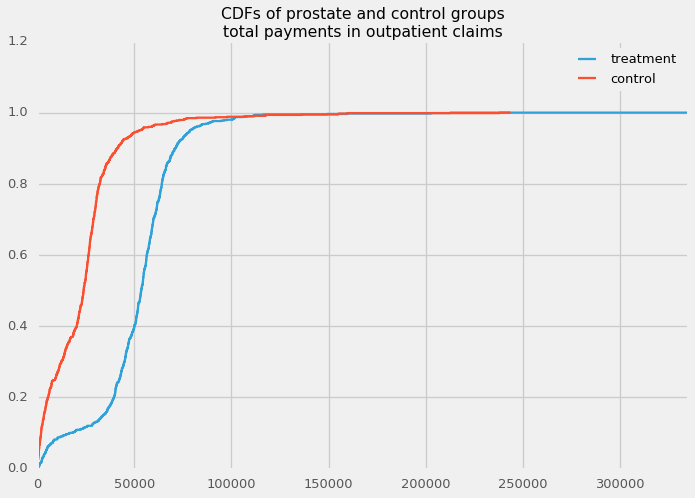

In [318]:
at = treatmentoutpatient['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ac = controloutpatient['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.title('CDFs of prostate and control groups\ntotal payments in outpatient claims')

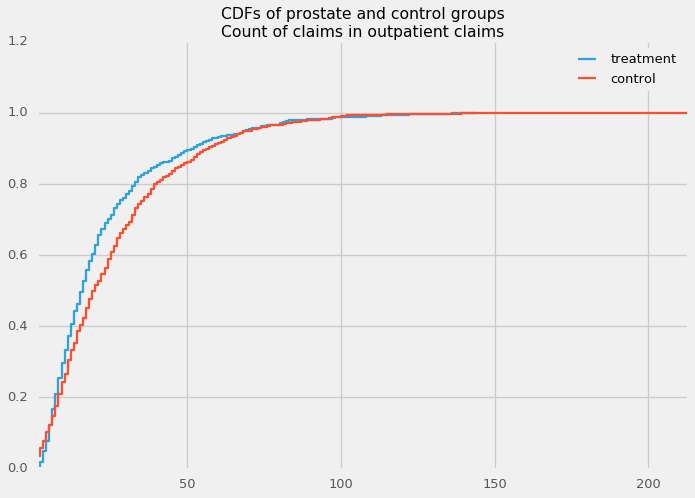

In [319]:
at = treatmentoutpatient['claim_count'].value_counts(normalize=True).sort_index().cumsum()
ac = controloutpatient['claim_count'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.title('CDFs of prostate and control groups\nCount of claims in outpatient claims')

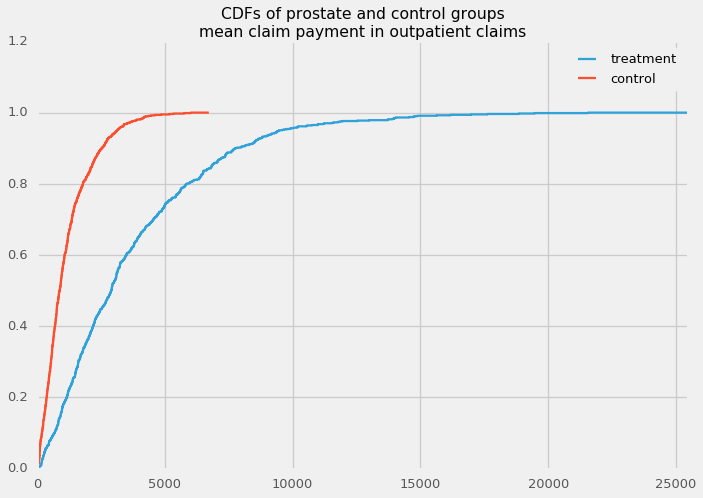

In [320]:
at = treatmentoutpatient['mean_claim_amt'].value_counts(normalize=True).sort_index().cumsum()
ac = controloutpatient['mean_claim_amt'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.title('CDFs of prostate and control groups\nmean claim payment in outpatient claims')

# <font color="#E56717">Claims in the Carrier File (Physician/Supplier Part B or NCH)</font>

* <span style="font-size:1.5em;">Most of these claims are from physicians</span>
* <span style="font-size:1.5em;">They can also be from:</span>
    * <span style="font-size:1.5em;">other health personnel</span>
    * <span style="font-size:1.5em;">labs</span>
    * <span style="font-size:1.5em;">freestanding ambulatory care centers</span>
* <span style="font-size:1.5em;">Include physician services that occur in a range of settings - office, hospital, nursing home, etc.</span>

# <font color="#E56717">Structure of Carrier Claims</font>

* <span style="font-size:1.5em;">Based on the filling form (HCFA 1500)</span>
* <span style="font-size:1.5em;">Bill, as submitted, can have variable length</span>
* <span style="font-size:1.5em;">Each bill has a common component, called the "header." The header includes demographic information about the patient with some diagnoses</span>
* <span style="font-size:1.5em;">Each bill includes space for all services provided during a visit - these are called line items</span>

# <font color="#E56717">More about line items</font>

* <span style="font-size:1.5em;">If during a doctor visit a patient has:</span>
    * <span style="font-size:1.5em;">office visit</span>
    * <span style="font-size:1.5em;">EKG</span>
    * <span style="font-size:1.5em;">Chest X-ray</span>
    * <span style="font-size:1.5em;">CBC</span>
    * <span style="font-size:1.5em;">This patient would have 4 line items</span>
* <span style="font-size:1.5em;">Each of the line items would have an associated diagnosis as to why the service was provided</span>
* <span style="font-size:1.5em;">So it is clear why different claims would have different lengths</span>

# <font color="#E56717">To make the Carrier data easier to use</font>

* <span style="font-size:1.5em;">The bills are turned into fixed-length records</span>
* <span style="font-size:1.5em;">Each record includes the header (the summary information at the top of the form)</span>
* <span style="font-size:1.5em;">One line item</span>
* <span style="font-size:1.5em;">In the SEER-Medicare data, the example with 4 line items, there would be four records, each with a common header and a unique line item</span>

# <font color="#E56717">Variables that researchers often use from the Carrier Data</font>

* <span style="font-size:1.5em;">HCPCS codes for the service provided</span>
* <span style="font-size:1.5em;">Diagnoses</span>
    * <span style="font-size:1.5em;">Head has diagnoses for existing health conditions</span>
    * <span style="font-size:1.5em;">Each line item must have a diagnosis that is the reason for the billed procedure, e.g. CBC w/ anemia dx</span>
* <span style="font-size:1.5em;">Charges and amount reimbursed</span>
    * <span style="font-size:1.5em;">line item and total for the bill</span>
    * <span style="font-size:1.5em;">copayments and deductibles</span>
* <span style="font-size:1.5em;">Dates of service</span>
    * <span style="font-size:1.5em;">claim from/through in the header can span some time</span>
    * <span style="font-size:1.5em;">First expenditure/last ependiture in line item must cover the actual dates of service</span>
* <span style="font-size:1.5em;">Provider information</span>
    * <span style="font-size:1.5em;">Place of service - office, hospital, etc</span>
    * <span style="font-size:1.5em;">UPIN for the physician (encrypted)</span>
    * <span style="font-size:1.5em;">Doctor specialty (self-reported)
    
   
# <font color="#E56717">Denied Claims in Carrier Data</font>

* <span style="font-size:1.5em;">Entirely denied claims ARE included in the Carrier file</span>
* <span style="font-size:1.5em;">Denied Line items (on otherwise approved claims) are included in the Carrier file</span>
    * <span style="font-size:1.5em;">about 20% of all line items are denied (varies by type of care)</span>
    * <span style="font-size:1.5em;">recommend deleting denied line items prior to analysis</span>
    * <span style="font-size:1.5em;">denied line items often represent services received by the beneficiary but not approved for reimbursement by Medicare</span>
        * <span style="font-size:1.5em;">non covered benefits</span>
        * <span style="font-size:1.5em;">bundling</span>
        * <span style="font-size:1.5em;">accidental duplicate billing</span>

# <font color="#E56717">Physican (NCH) payments</font>

* <span style="font-size:1.5em;">Payments in the NCH file are based on service. For each service, or line item, there is an allowed amount which is divided into the Medicare and patient responsibility</span>


# <font color="#E56717">Line item payment by Medicare:</font>

* <span style="font-size:1.5em;">Line Payment Amount + Line Interest Amount:</span>
* <span style="font-size:1.5em;">linepmt - Amount of payment made to provider and/or beneficiary for the services covered</span>
* <span style="font-size:1.5em;">lintamt - Amount of interest to be paid for this line item service on the non-institutional claim</span>


# <font color="#E56717">Line item beneficiary responsibility:</font>

* <span style="font-size:1.5em;">LINE BENEFICIARY PART B DEDUCTIBLE AMOUNT: ldedamt: The amount of money for which the intermediary or carrier has determined tha the beneficiary is liable for the Part B deductible on the CWFB claim</span>
* <span style="font-size:1.5em;">Line item Coinsurance amount:  coinamt: The beneficiary coinsurance liability amount for this line item service on the non-institutional claim.</span>


# <font color="#E56717">Total claim payment by Medicare:</font>

* <span style="font-size:1.5em;">Claim Payment Amount + sum of line interest amounts</span>
* <span style="font-size:1.5em;">pmt_amt + sum of lintamt</span>


# <font color="#E56717">Total beneficiary responsibility for claim:</font>

* <span style="font-size:1.5em;">Sum of line item co-payments and deductibles: ldedamt + coinamt</span>

# <font color="#E56717">Total payment due provider:</font>

* <span style="font-size:1.5em;">Medicare payment + Beneficiary co-pay/deduct + Claim Primary Payer Amount</span>
* <span style="font-size:1.5em;">Claim Primary Payer Amount: prpayamt</span>
* <span style="font-size:1.5em;">Note: Claim Payment Amount , pmt_amt, repeats for each line item on the claim. Be careful to only count it once.</span>

In [321]:
di = pd.read_pickle('pure_goodindices_nch.pickle')

In [322]:
di = di.set_index('patient_id', drop=False)

In [323]:
ditreatment = di[di.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dicontrol = di[di.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

In [324]:
ditreatment.shape

(222865, 81)

In [325]:
dicontrol.shape

(287460, 81)

In [326]:
ditreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
ditreatment['site1'] = df_all_good_indices['site1']

In [327]:
dicontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dicontrol['site1'] = df_all_good_indices['site1']

In [328]:
ditreatment.shape, dicontrol.shape

((222865, 83), (287460, 83))

In [330]:
ditreatment['claim_from_date_new'] = ditreatment.claim_from_date.astype('str').str.replace('\.0','')
ditreatment['claim_from_date_new'] = ditreatment.claim_from_date_new.str.rjust(8,'0')

ditreatment['claim_through_date_new'] = ditreatment.claim_through_date.astype('str').str.replace('\.0','')
ditreatment['claim_through_date_new'] = ditreatment.claim_through_date_new.str.rjust(8,'0')

In [331]:
dicontrol['claim_from_date_new'] = dicontrol.claim_from_date.astype('str').str.replace('\.0','')
dicontrol['claim_from_date_new'] = dicontrol.claim_from_date_new.str.rjust(8,'0')

dicontrol['claim_through_date_new'] = dicontrol.claim_through_date.astype('str').str.replace('\.0','')
dicontrol['claim_through_date_new'] = dicontrol.claim_through_date_new.str.rjust(8,'0')

In [332]:
ditreatment['claim_from_date_new'] = pd.to_datetime(ditreatment['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

ditreatment['claim_through_date_new'] = pd.to_datetime(ditreatment['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

In [333]:
dicontrol['claim_from_date_new'] = pd.to_datetime(dicontrol['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dicontrol['claim_through_date_new'] = pd.to_datetime(dicontrol['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

In [334]:
ditreatment.head()

,registry,patient_id,state_cd,cnty_cd,clm_type,claim_from_date,claim_through_date,hcfaspec,prtcptg,proindcd,...,dup_chk,hgb_rslt,hgb_type,year,rec_count,pmtdnlcd,yrdx_plus_modx,site1,claim_from_date_new,claim_through_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
0231464080,2,0231464080,7,0,7,2072006,2072006,30,2,A,...,NaN,0,NaN,2006,1,1,2006-09-01,Prostate gland,2006-02-07,2006-02-07
0231464080,2,0231464080,7,0,7,2062006,2062006,02,5,A,...,NaN,0,NaN,2006,1,1,2006-09-01,Prostate gland,2006-02-06,2006-02-06
0231464080,2,0231464080,7,0,7,2132006,2132006,02,3,A,...,NaN,0,NaN,2006,1,1,2006-09-01,Prostate gland,2006-02-13,2006-02-13
0231464080,2,0231464080,7,0,7,11032006,11032006,69,1,A,...,NaN,0,NaN,2006,1,1,2006-09-01,Prostate gland,2006-11-03,2006-11-03
0231464080,2,0231464080,7,0,7,11032006,11032006,69,1,A,...,NaN,0,NaN,2006,2,1,2006-09-01,Prostate gland,2006-11-03,2006-11-03


In [335]:
ditreatment.columns

Index(['registry', 'patient_id', 'state_cd', 'cnty_cd', 'clm_type',
       'claim_from_date', 'claim_through_date', 'hcfaspec', 'prtcptg',
       'proindcd', 'pay80cd', 'dedind', 'payindcd', 'mtuscnt', 'mtusind',
       'hcpcs', 'mf1', 'mf2', 'mf3', 'mf4', 'lsubmamt', 'lalowamt', 'hcfatype',
       'plcsrvc', 'line_first_expense_date', 'line_last_expense_date',
       'srvc_cnt', 'linediag', 'linepmt', 'ldedamt', 'lprpayat', 'lprpaycd',
       'lbenpmt', 'lprvpmt', 'coinamt', 'lintamt', 'dedapply', 'prpayamt',
       'pmt_amt', 'allowamt', 'sbmtamt', 'prov_pmt', 'prpyalow', 'astnt_cd',
       'hcpcs_yr', 'prv_type', 'prvstate', 'clinecnt', 'link_num',
       'daily_process_date', 'pdgns_cd', 'cdgncnt', 'dgn_cd1', 'dgn_cd2',
       'dgn_cd3', 'dgn_cd4', 'dgn_cd5', 'dgn_cd6', 'dgn_cd7', 'dgn_cd8',
       'dgn_cd9', 'dgn_cd10', 'dgn_cd11', 'dgn_cd12', 'betos', 'benepaid',
       'cwf_claim_accretion_date', 'nchben_pmt', 'cln_tril', 'ansthcnt',
       'llabamt', 'llab_num', 'price_cd', 'ps

In [349]:
goodcols = ['patient_id','claim_from_date_new','yrdx_plus_modx','hcpcs','link_num','srvc_cnt',
   'linediag','rec_count','pmt_amt','lintamt','ldedamt','coinamt','prpayamt',
           'prov_pmt']

ditreatment[goodcols].head()

,patient_id,claim_from_date_new,yrdx_plus_modx,hcpcs,link_num,srvc_cnt,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0231464080,0231464080,2006-02-07,2006-09-01,71020,1234625,1,486,1,0.00,0.0,12.1,0.00,0.0,0.00
0231464080,0231464080,2006-02-06,2006-09-01,99243,1234626,1,55090,1,12.11,0.0,111.9,3.03,0.0,12.11
0231464080,0231464080,2006-02-13,2006-09-01,49505,1234627,1,55090,1,379.98,0.0,0.0,95.00,0.0,379.98
0231464080,0231464080,2006-11-03,2006-09-01,36415,1347953,1,2720,1,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,80053,1347953,1,2720,2,29.21,0.0,0.0,0.00,0.0,29.21


# <font color="#E56717">Can use patient_id + claim_from_date_new + link_num as the claim_id primary key</font>

In [350]:
dicontrol[goodcols].head(35)

,patient_id,claim_from_date_new,yrdx_plus_modx,hcpcs,link_num,srvc_cnt,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0240429030,0240429030,2006-04-12,2007-11-01,82088,1421878,1,25000,1,56.94,0.0,0.00,0.00,0.0,56.94
0240429030,0240429030,2006-04-12,2007-11-01,36415,1421879,1,25000,1,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,80053,1421879,1,25000,2,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,80061,1421879,1,25000,3,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,82533,1421879,1,25000,4,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,82627,1421879,1,25000,5,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,83036,1421879,1,25000,6,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,83835,1421880,1,25000,1,23.67,0.0,0.00,0.00,0.0,23.67
0240429030,0240429030,2006-05-02,2007-11-01,99214,1439321,1,25050,1,9.53,0.0,90.65,0.00,0.0,9.53


In [347]:
ditreatment[goodcols][ditreatment.coinamt == ditreatment.coinamt.value_counts().index[1]]

,patient_id,claim_from_date_new,hcpcs,link_num,srvc_cnt,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,
8800045422,8800045422,2006-11-09,36410,617570,1,79093,2,88.04,0.0,0.00,4.03,0.0,88.04
8809063395,8809063395,2006-01-24,99214,2640058,1,4770,1,16.11,0.0,64.33,4.03,0.0,16.11
8864092491,8864092491,2006-09-07,76075,4234677,1,73301,1,16.12,0.0,124.00,4.03,0.0,16.12
8832044303,8832044303,2007-10-22,78480,4771982,1,78650,3,101.74,0.0,0.00,4.03,0.0,101.74
8847014481,8847014481,2009-11-23,93320,2532123,1,3950,4,630.30,0.0,0.00,4.03,0.0,630.30
8848098352,8848098352,2009-02-12,99213,599397,1,2722,1,16.10,0.0,42.50,4.03,0.0,16.10
2136138000,2136138000,2010-09-01,77421,1641475,1,185,1,16.12,0.0,0.00,4.03,0.0,16.12
2136138000,2136138000,2010-08-19,77421,1985661,1,185,1,16.12,0.0,0.00,4.03,0.0,16.12
2607022093,2607022093,2010-09-16,77421,140040,1,185,1,112.84,0.0,0.00,4.03,0.0,112.84


# <font color="#E56717">Now restrict to those claims where claim_from_date_new is later in time than yrdx_plus_modx</font>

In [351]:
ditreatment['time_delta'] = ditreatment['claim_from_date_new'] - ditreatment['yrdx_plus_modx']

dicontrol['time_delta'] = dicontrol['claim_from_date_new'] - dicontrol['yrdx_plus_modx']

In [352]:
ditreatment['delta_days'] = ditreatment['time_delta'].apply(make_days)
dicontrol['delta_days'] = dicontrol['time_delta'].apply(make_days)

In [355]:
goodcols = ['patient_id','claim_from_date_new','yrdx_plus_modx','delta_days','link_num','srvc_cnt',
   'linediag','rec_count','pmt_amt','lintamt','ldedamt','coinamt','prpayamt',
           'prov_pmt']

In [356]:
ditreatment[goodcols].head(15)

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,srvc_cnt,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0231464080,0231464080,2006-02-07,2006-09-01,-206,1234625,1,486,1,0.00,0.0,12.1,0.00,0.0,0.00
0231464080,0231464080,2006-02-06,2006-09-01,-207,1234626,1,55090,1,12.11,0.0,111.9,3.03,0.0,12.11
0231464080,0231464080,2006-02-13,2006-09-01,-200,1234627,1,55090,1,379.98,0.0,0.0,95.00,0.0,379.98
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,1,2720,1,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,1,2720,2,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,1,2720,3,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-06,2006-09-01,66,1347954,1,185,1,78.33,0.0,0.0,19.58,0.0,78.33
0231464080,0231464080,2006-08-01,2006-09-01,-31,1465486,1,2720,1,23.57,0.0,0.0,0.00,0.0,23.57
0231464080,0231464080,2006-08-01,2006-09-01,-31,1465486,1,2720,2,23.57,0.0,0.0,0.00,0.0,23.57


In [357]:
dicontrol[goodcols].head(10)

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,srvc_cnt,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421878,1,25000,1,56.94,0.0,0.00,0.00,0.0,56.94
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421879,1,25000,1,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421879,1,25000,2,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421879,1,25000,3,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421879,1,25000,4,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421879,1,25000,5,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421879,1,25000,6,96.62,0.0,0.00,0.00,0.0,96.62
0240429030,0240429030,2006-04-12,2007-11-01,-568,1421880,1,25000,1,23.67,0.0,0.00,0.00,0.0,23.67
0240429030,0240429030,2006-05-02,2007-11-01,-548,1439321,1,25050,1,9.53,0.0,90.65,0.00,0.0,9.53


In [358]:
good_claims_filter_treatment = ditreatment.delta_days > 0
good_claims_filter_control = dicontrol.delta_days > 0

In [359]:
ditreatmentgoodclaims = ditreatment[good_claims_filter_treatment].copy()
dicontrolgoodclaims = dicontrol[good_claims_filter_control].copy()

In [360]:

ditreatmentgoodclaims[goodcols].head()

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,srvc_cnt,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,1,2720,1,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,1,2720,2,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,1,2720,3,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-06,2006-09-01,66,1347954,1,185,1,78.33,0.0,0.0,19.58,0.0,78.33
0231464080,0231464080,2006-10-09,2006-09-01,38,1692374,1,185,1,168.26,0.0,0.0,19.58,0.0,168.26


In [361]:

ditreatmentgoodclaims['prpayamt'].describe()

count    153573.000000
mean          1.906466
std          58.872223
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4512.210000
Name: prpayamt, dtype: float64

In [362]:
dicontrolgoodclaims['prpayamt'].describe()

count    208166.000000
mean          6.014941
std         131.897363
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        6770.200000
Name: prpayamt, dtype: float64

# <font color="#E56717">Can use patient_id + claim_from_date_new + link_num as the claim_id primary key</font>

In [363]:
type(ditreatmentgoodclaims.patient_id[0]), type(ditreatmentgoodclaims.claim_from_date_new.astype('str')[0])

(str, str)

In [364]:
type(ditreatmentgoodclaims.link_num.astype('str')[0])

str

In [365]:
a = ditreatmentgoodclaims.patient_id + ditreatmentgoodclaims.claim_from_date_new.astype('str') + \
ditreatmentgoodclaims.link_num.astype('str')

ditreatmentgoodclaims['claim_id'] = a

In [366]:
a = dicontrolgoodclaims.patient_id + dicontrolgoodclaims.claim_from_date_new.astype('str') + \
dicontrolgoodclaims.link_num.astype('str')

dicontrolgoodclaims['claim_id'] = a

In [368]:
goodcols = ['patient_id','claim_from_date_new','yrdx_plus_modx','delta_days','link_num','claim_id',
   'linediag','rec_count','pmt_amt','lintamt','ldedamt','coinamt','prpayamt',
           'prov_pmt']

In [369]:
ditreatmentgoodclaims[goodcols].head()


,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,claim_id,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,02314640802006-11-031347953,2720,1,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,02314640802006-11-031347953,2720,2,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,02314640802006-11-031347953,2720,3,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-06,2006-09-01,66,1347954,02314640802006-11-061347954,185,1,78.33,0.0,0.0,19.58,0.0,78.33
0231464080,0231464080,2006-10-09,2006-09-01,38,1692374,02314640802006-10-091692374,185,1,168.26,0.0,0.0,19.58,0.0,168.26


In [371]:
ditreatmentgoodclaims.linediag.value_counts(normalize=True)

185      0.250077
2724     0.019476
25000    0.017809
7020     0.017301
79093    0.016917
V0481    0.016012
42731    0.015426
4019     0.013629
41401    0.012502
7242     0.012496
4011     0.012378
2720     0.010269
2382     0.008289
78650    0.007918
5856     0.007879
7393     0.007853
2859     0.006967
71516    0.006837
2449     0.006479
71941    0.006446
78079    0.006355
2722     0.005646
41400    0.005509
36616    0.005418
36252    0.005222
7391     0.004864
V5861    0.004454
71946    0.004278
78605    0.004278
5990     0.004050
           ...   
36845    0.000007
37739    0.000007
1893     0.000007
7569     0.000007
1529     0.000007
V655     0.000007
9170     0.000007
29655    0.000007
7827     0.000007
71104    0.000007
85100    0.000007
45381    0.000007
71908    0.000007
40511    0.000007
71650    0.000007
42651    0.000007
8469     0.000007
30270    0.000007
72743    0.000007
2558     0.000007
04112    0.000007
32720    0.000007
30500    0.000007
27801    0.000007
45829    0

In [372]:
ditreatmentgoodclaims.lintamt.sum()

57.910000000000025

In [373]:
ditreatmentgoodclaims.prpayamt.sum()

292781.76000000036

In [374]:
dicontrolgoodclaims.prpayamt.sum()

1252106.1800000044

In [377]:
dicontrolgoodclaims.coinamt.value_counts().head()

0.00      70780
108.88     1750
126.11     1079
23.38      1021
108.02      960
Name: coinamt, dtype: int64

In [378]:
dicontrolgoodclaims[goodcols][dicontrolgoodclaims.coinamt == 108.88]

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,claim_id,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
8809080305,8809080305,2009-06-01,2009-03-01,92,867210,88090803052009-06-01867210,185,1,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-01,2009-03-01,92,867210,88090803052009-06-01867210,185,2,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-01,2009-03-01,92,867210,88090803052009-06-01867210,185,3,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-01,2009-03-01,92,867210,88090803052009-06-01867210,185,4,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-01,2009-03-01,92,867210,88090803052009-06-01867210,185,5,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-08,2009-03-01,99,867213,88090803052009-06-08867213,185,1,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-08,2009-03-01,99,867213,88090803052009-06-08867213,185,2,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-08,2009-03-01,99,867213,88090803052009-06-08867213,185,3,2177.70,0.0,0.0,108.88,0.0,2177.70
8809080305,8809080305,2009-06-08,2009-03-01,99,867213,88090803052009-06-08867213,185,4,2177.70,0.0,0.0,108.88,0.0,2177.70


In [379]:
dicontrolgoodclaims.lintamt.value_counts().head()

0.00    207481
0.01       122
0.03        83
0.04        57
0.02        52
Name: lintamt, dtype: int64

In [380]:
dicontrolgoodclaims[goodcols][dicontrolgoodclaims.lintamt == 0.01]

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,claim_id,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,2,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,3,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,4,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,5,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,6,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,8,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,9,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,10,516.88,0.01,0.0,5.78,0.0,516.88
2200086525,2200086525,2006-08-10,2006-03-01,162,1919317,22000865252006-08-101919317,185,11,516.88,0.01,0.0,5.78,0.0,516.88


In [382]:
ditreatmentgoodclaims[goodcols].head()

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,claim_id,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,02314640802006-11-031347953,2720,1,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,02314640802006-11-031347953,2720,2,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-03,2006-09-01,63,1347953,02314640802006-11-031347953,2720,3,29.21,0.0,0.0,0.00,0.0,29.21
0231464080,0231464080,2006-11-06,2006-09-01,66,1347954,02314640802006-11-061347954,185,1,78.33,0.0,0.0,19.58,0.0,78.33
0231464080,0231464080,2006-10-09,2006-09-01,38,1692374,02314640802006-10-091692374,185,1,168.26,0.0,0.0,19.58,0.0,168.26


In [383]:
dinchtreatmentgroup = ditreatmentgoodclaims.groupby(['patient_id','claim_id'])

dinchcontrolgroup = dicontrolgoodclaims.groupby(['patient_id','claim_id'])

In [393]:
paymentcols = ['pmt_amt','coinamt','prpayamt','ldedamt','lintamt'] # sum over coinamt, ldedamt and lintamt

In [386]:
ditreatmentgoodclaims.ldedamt.value_counts().head()

0.00      149312
135.00       110
147.00        85
66.39         77
62.63         68
Name: ldedamt, dtype: int64

In [389]:
ditreatmentgoodclaims[goodcols][ditreatmentgoodclaims.ldedamt == 135.00]

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,claim_id,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
0268487040,0268487040,2008-01-08,2007-11-01,68,1024395,02684870402008-01-081024395,185,1,176.25,0.0,135.0,44.06,0.00,176.25
2582072045,2582072045,2008-01-08,2006-02-01,706,350887,25820720452008-01-08350887,5781,1,1.84,0.0,135.0,0.46,0.00,1.84
2595053065,2595053065,2008-03-25,2007-08-01,237,3728588,25950530652008-03-253728588,185,1,34.57,0.0,135.0,8.64,819.00,34.57
4205086084,4205086084,2008-08-18,2007-11-01,291,3620710,42050860842008-08-183620710,185,1,3037.35,0.0,135.0,130.27,0.00,3037.35
2658007072,2658007072,2008-01-17,2007-03-01,322,3767777,26580070722008-01-173767777,185,1,81.59,0.0,135.0,8.64,347.31,81.59
8728033439,8728033439,2008-01-08,2007-10-01,99,973894,87280334392008-01-08973894,185,1,176.25,0.0,135.0,44.06,0.00,176.25
8804019323,8804019323,2008-01-07,2007-08-01,159,458751,88040193232008-01-07458751,185,1,34.57,0.0,135.0,8.64,0.00,34.57
8810023332,8810023332,2008-01-08,2007-03-01,313,690409,88100233322008-01-08690409,08881,1,182.14,0.0,135.0,7.00,0.00,182.14
8820014303,8820014303,2008-01-04,2007-11-01,64,280529,88200143032008-01-04280529,185,1,34.57,0.0,135.0,8.64,0.00,34.57


In [392]:
ditreatmentgoodclaims[goodcols][ditreatmentgoodclaims.claim_id == '88290873312008-01-04631704']

,patient_id,claim_from_date_new,yrdx_plus_modx,delta_days,link_num,claim_id,linediag,rec_count,pmt_amt,lintamt,ldedamt,coinamt,prpayamt,prov_pmt
patient_id,,,,,,,,,,,,,,
8829087331,8829087331,2008-01-04,2006-09-01,490,631704,88290873312008-01-04631704,7295,1,251.74,0.0,0.0,46.43,0.0,251.74
8829087331,8829087331,2008-01-04,2006-09-01,490,631704,88290873312008-01-04631704,7295,2,251.74,0.0,135.0,16.50,0.0,251.74


In [394]:
paymentcols = ['pmt_amt','coinamt','prpayamt','ldedamt','lintamt'] # sum over coinamt, ldedamt and lintamt

In [395]:
dinchtreatmentgroup = ditreatmentgoodclaims.groupby(['patient_id','claim_id'])

dinchcontrolgroup = dicontrolgoodclaims.groupby(['patient_id','claim_id'])

In [400]:
treatmentnchagg = dinchtreatmentgroup[paymentcols].agg([np.max, np.sum ])
controlnchagg = dinchcontrolgroup[paymentcols].agg([np.max, np.sum])

In [401]:
treatmentnchagg.head()

pmt_amt         coinamt         \
                                          amax     sum    amax    sum   
patient_id claim_id                                                     
0230482051 02304820512013-01-163824864   28.29   56.58    0.00   0.00   
           02304820512013-01-303824865    0.00    0.00    0.00   0.00   
           02304820512013-04-304424568   40.47   80.94    5.18  10.33   
           02304820512013-05-144424569   40.60  121.80    5.18  10.36   
           02304820512013-05-214424570   40.60  243.60    5.18  10.36   

                                       prpayamt      ldedamt        lintamt  \
                                           amax  sum    amax    sum    amax   
patient_id claim_id                                                           
0230482051 02304820512013-01-163824864      0.0  0.0    0.00   0.00     0.0   
           02304820512013-01-303824865      0.0  0.0   79.85  79.85     0.0   
           02304820512013-04-304424568      0.0  0.0    0.16   0.16     0.0   
           02304820512013-05-144424569      0.0  0.0    0.00   0.00     0.0   
           02304820512013-05-214424570      0.0  0.0    0.00   0.00     0.0   

                                             
                                        sum  
patient_id claim_id                          
0230482051 02304820512013-01-163824864  0.0  
           02304820512013-01-303824865  0.0  
           02304820512013-04-304424568  0.0  
           02304820512013-05-144424569  0.0  
           02304820512013-05-214424570  0.0

In [403]:
treatmentnchagg.reset_index(inplace=True)
controlnchagg.reset_index(inplace=True)

treatmentnchagg = treatmentnchagg.set_index('patient_id', drop=False)
controlnchagg = controlnchagg.set_index('patient_id', drop=False)

treatmentnchagg.head()

patient_id                     claim_id pmt_amt         coinamt  \
                                                       amax     sum    amax   
patient_id                                                                    
0230482051  0230482051  02304820512013-01-163824864   28.29   56.58    0.00   
0230482051  0230482051  02304820512013-01-303824865    0.00    0.00    0.00   
0230482051  0230482051  02304820512013-04-304424568   40.47   80.94    5.18   
0230482051  0230482051  02304820512013-05-144424569   40.60  121.80    5.18   
0230482051  0230482051  02304820512013-05-214424570   40.60  243.60    5.18   

                  prpayamt      ldedamt        lintamt       
              sum     amax  sum    amax    sum    amax  sum  
patient_id                                                   
0230482051   0.00      0.0  0.0    0.00   0.00     0.0  0.0  
0230482051   0.00      0.0  0.0   79.85  79.85     0.0  0.0  
0230482051  10.33      0.0  0.0    0.16   0.16     0.0  0.0  
0230482051  10.36      0.0  0.0    0.00   0.00     0.0  0.0  
0230482051  10.36      0.0  0.0    0.00   0.00     0.0  0.0

In [405]:
treatmentnchagg.columns = treatmentnchagg.columns.droplevel()
treatmentnchagg.head()

,,,amax,sum,amax,sum,amax,sum,amax,sum,amax,sum
patient_id,,,,,,,,,,,,
0230482051,0230482051,02304820512013-01-163824864,28.29,56.58,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
0230482051,0230482051,02304820512013-01-303824865,0.00,0.00,0.00,0.00,0.0,0.0,79.85,79.85,0.0,0.0
0230482051,0230482051,02304820512013-04-304424568,40.47,80.94,5.18,10.33,0.0,0.0,0.16,0.16,0.0,0.0
0230482051,0230482051,02304820512013-05-144424569,40.60,121.80,5.18,10.36,0.0,0.0,0.00,0.00,0.0,0.0
0230482051,0230482051,02304820512013-05-214424570,40.60,243.60,5.18,10.36,0.0,0.0,0.00,0.00,0.0,0.0


In [406]:
treatmentnchagg.columns = ['patient_id','claim_id','pmt_amt_max','pmt_amt_sum',
                          'coinamt_max','coinamt_sum','prpayamt_max','prpayamt_sum',
                          'ldedamt_max','ldedamt_sum','lintamt_max','lintamt_sum']

treatmentnchagg.head()

,patient_id,claim_id,pmt_amt_max,pmt_amt_sum,coinamt_max,coinamt_sum,prpayamt_max,prpayamt_sum,ldedamt_max,ldedamt_sum,lintamt_max,lintamt_sum
patient_id,,,,,,,,,,,,
0230482051,0230482051,02304820512013-01-163824864,28.29,56.58,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
0230482051,0230482051,02304820512013-01-303824865,0.00,0.00,0.00,0.00,0.0,0.0,79.85,79.85,0.0,0.0
0230482051,0230482051,02304820512013-04-304424568,40.47,80.94,5.18,10.33,0.0,0.0,0.16,0.16,0.0,0.0
0230482051,0230482051,02304820512013-05-144424569,40.60,121.80,5.18,10.36,0.0,0.0,0.00,0.00,0.0,0.0
0230482051,0230482051,02304820512013-05-214424570,40.60,243.60,5.18,10.36,0.0,0.0,0.00,0.00,0.0,0.0


In [407]:
controlnchagg.columns = controlnchagg.columns.droplevel()
treatmentnchagg.columns = ['patient_id','claim_id','pmt_amt_max','pmt_amt_sum',
                          'coinamt_max','coinamt_sum','prpayamt_max','prpayamt_sum',
                          'ldedamt_max','ldedamt_sum','lintamt_max','lintamt_sum']
controlnchagg.head()

,,,amax,sum,amax,sum,amax,sum,amax,sum,amax,sum
patient_id,,,,,,,,,,,,
0238421020,0238421020,02384210202006-05-171236686,361.30,3613.00,9.03,90.30,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-05-171236687,439.19,1317.57,50.35,109.81,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-06-143525624,22.04,66.12,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-06-151513007,46.38,46.38,11.59,11.59,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-06-203525622,118.19,118.19,29.55,29.55,0.0,0.0,0.0,0.0,0.0,0.0


In [408]:
controlnchagg.columns = ['patient_id','claim_id','pmt_amt_max','pmt_amt_sum',
                          'coinamt_max','coinamt_sum','prpayamt_max','prpayamt_sum',
                          'ldedamt_max','ldedamt_sum','lintamt_max','lintamt_sum']
controlnchagg.head()

,patient_id,claim_id,pmt_amt_max,pmt_amt_sum,coinamt_max,coinamt_sum,prpayamt_max,prpayamt_sum,ldedamt_max,ldedamt_sum,lintamt_max,lintamt_sum
patient_id,,,,,,,,,,,,
0238421020,0238421020,02384210202006-05-171236686,361.30,3613.00,9.03,90.30,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-05-171236687,439.19,1317.57,50.35,109.81,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-06-143525624,22.04,66.12,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-06-151513007,46.38,46.38,11.59,11.59,0.0,0.0,0.0,0.0,0.0,0.0
0238421020,0238421020,02384210202006-06-203525622,118.19,118.19,29.55,29.55,0.0,0.0,0.0,0.0,0.0,0.0


# <font color="#E56717">Now need to drop columns pmt_amt_sum, coinamt_max, prpayamt_sum, ldedamt_max, and lintamt_max</font>

In [412]:
#del treatmentnchagg['pmt_amt_sum']
#del treatmentnchagg['coinamt_max']
del treatmentnchagg['prpayamt_sum']
del treatmentnchagg['ldedamt_max']
del treatmentnchagg['lintamt_max']

In [413]:
del controlnchagg['pmt_amt_sum']
del controlnchagg['coinamt_max']
del controlnchagg['prpayamt_sum']
del controlnchagg['ldedamt_max']
del controlnchagg['lintamt_max']

In [414]:
treatmentnchagg.head()

,patient_id,claim_id,pmt_amt_max,coinamt_sum,prpayamt_max,ldedamt_sum,lintamt_sum
patient_id,,,,,,,
0230482051,0230482051,02304820512013-01-163824864,28.29,0.00,0.0,0.00,0.0
0230482051,0230482051,02304820512013-01-303824865,0.00,0.00,0.0,79.85,0.0
0230482051,0230482051,02304820512013-04-304424568,40.47,10.33,0.0,0.16,0.0
0230482051,0230482051,02304820512013-05-144424569,40.60,10.36,0.0,0.00,0.0
0230482051,0230482051,02304820512013-05-214424570,40.60,10.36,0.0,0.00,0.0


In [415]:
controlnchagg['total_amt_claim'] = controlnchagg[['pmt_amt_max','coinamt_sum','prpayamt_max',
                            'ldedamt_sum','lintamt_sum']].sum(axis=1)

In [416]:
treatmentnchagg['total_amt_claim'] = treatmentnchagg[['pmt_amt_max','coinamt_sum','prpayamt_max',
                            'ldedamt_sum','lintamt_sum']].sum(axis=1)

In [417]:
treatmentnchagg.head()

,patient_id,claim_id,pmt_amt_max,coinamt_sum,prpayamt_max,ldedamt_sum,lintamt_sum,total_amt_claim
patient_id,,,,,,,,
0230482051,0230482051,02304820512013-01-163824864,28.29,0.00,0.0,0.00,0.0,28.29
0230482051,0230482051,02304820512013-01-303824865,0.00,0.00,0.0,79.85,0.0,79.85
0230482051,0230482051,02304820512013-04-304424568,40.47,10.33,0.0,0.16,0.0,50.96
0230482051,0230482051,02304820512013-05-144424569,40.60,10.36,0.0,0.00,0.0,50.96
0230482051,0230482051,02304820512013-05-214424570,40.60,10.36,0.0,0.00,0.0,50.96


# <font color="#E56717">Now need to group the above dataframes by patient_id and sum over total_amt_claim</font>

In [418]:
dicontrolgroup = controlnchagg.groupby('patient_id')

ditreatmentgroup = treatmentnchagg.groupby('patient_id')

In [419]:
controlnch = controlnchagg[['patient_id',
        'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
controlnch.columns = controlnch.columns.droplevel()
controlnch.columns = ['total_amt','claim_count','mean_claim_amt']
controlnch.head()

,total_amt,claim_count,mean_claim_amt
patient_id,,,
0238421020,7176.27,40,179.406750
0240429030,14644.29,104,140.810481
0256490040,9537.80,98,97.324490
0274484060,21666.39,156,138.887115
0275493070,19216.91,110,174.699182


In [420]:
controlnch.describe()

,total_amt,claim_count,mean_claim_amt
count,803.000000,803.000000,803.000000
mean,31076.357385,114.809465,286.649655
std,25573.306549,88.791343,206.592242
min,0.000000,1.000000,0.000000
25%,10054.910000,54.000000,142.874529
50%,23684.570000,94.000000,208.409245
75%,48383.195000,151.000000,375.755969
max,181753.710000,825.000000,1317.055870


In [421]:
treatmentnch = treatmentnchagg[['patient_id',
        'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
treatmentnch.columns = treatmentnch.columns.droplevel()
treatmentnch.columns = ['total_amt','claim_count','mean_claim_amt']
treatmentnch.head()

,total_amt,claim_count,mean_claim_amt
patient_id,,,
0230482051,620.99,11,56.453636
0231464080,29454.69,218,135.113257
0247481030,28633.86,225,127.261600
0266443090,12709.79,68,186.908676
0268487040,53237.51,125,425.900080


In [422]:
treatmentnch.describe()

,total_amt,claim_count,mean_claim_amt
count,800.000000,800.00000,800.000000
mean,18323.880012,94.57500,185.573587
std,19898.713067,82.38371,116.155871
min,0.000000,1.00000,0.000000
25%,5901.955000,38.00000,129.722621
50%,11250.485000,72.50000,156.501273
75%,23542.582500,131.25000,194.630655
max,172218.990000,781.00000,1120.771282


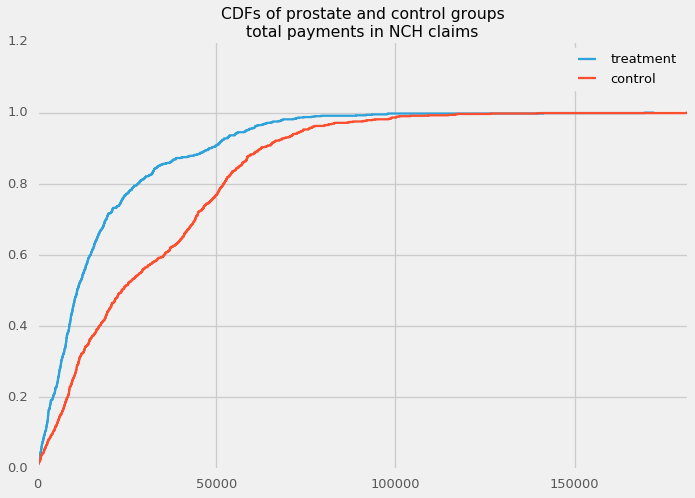

In [423]:
at = treatmentnch['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ac = controlnch['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.title('CDFs of prostate and control groups\ntotal payments in NCH claims')

# <font color="#E56717">Let's plot 1 - the CDFs for both the NCH payments and the Outpatient patients</font>

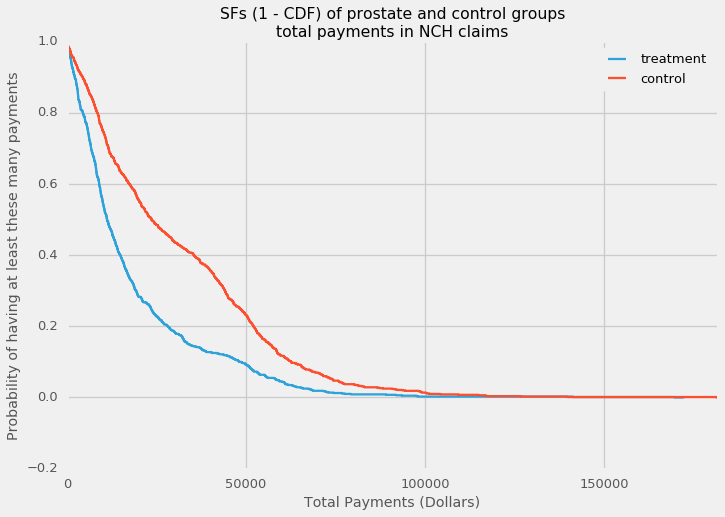

In [427]:
at = 1 -treatmentnch['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ac = 1 -controlnch['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.xlabel("Total Payments (Dollars)")
plt.ylabel("Probability of having at least these many payments")
plt.title('SFs (1 - CDF) of prostate and control groups\ntotal payments in NCH claims')

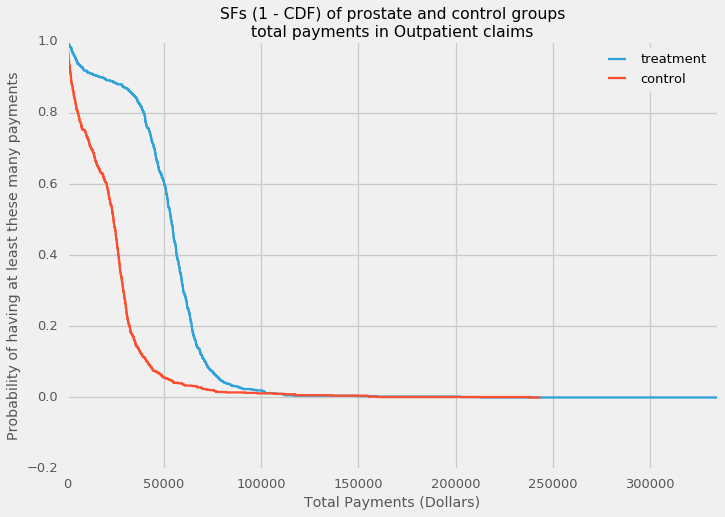

In [428]:
at = 1 -treatmentoutpatient['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ac = 1 -controloutpatient['total_amt'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.xlabel("Total Payments (Dollars)")
plt.ylabel("Probability of having at least these many payments")
plt.title('SFs (1 - CDF) of prostate and control groups\ntotal payments in Outpatient claims')

# <font color="#E56717">Need to combine the NCH and OUTPATIENT total payments</font>

In [432]:
controloutpatient.columns = ['total_amt_outpatient','claim_count_outpatient',
                            'mean_claim_amt_outpatient']
controloutpatient.head()

,total_amt_outpatient,claim_count_outpatient,mean_claim_amt_outpatient
patient_id,,,
0238421020,24798.17,12,2066.514167
0240429030,43216.57,23,1878.981304
0256490040,24402.37,20,1220.118500
0274484060,40460.28,18,2247.793333
0275493070,30265.17,14,2161.797857


In [433]:
controlnch.columns = ['total_amt_nch','claim_count_nch','mean_claim_amt_nch']
controlnch.head()

,total_amt_nch,claim_count_nch,mean_claim_amt_nch
patient_id,,,
0238421020,7176.27,40,179.406750
0240429030,14644.29,104,140.810481
0256490040,9537.80,98,97.324490
0274484060,21666.39,156,138.887115
0275493070,19216.91,110,174.699182


In [434]:
controloutpatientnch = pd.concat([controloutpatient, controlnch], axis=1)

In [435]:
controloutpatientnch.head()

,total_amt_outpatient,claim_count_outpatient,mean_claim_amt_outpatient,total_amt_nch,claim_count_nch,mean_claim_amt_nch
0238421020,24798.17,12.0,2066.514167,7176.27,40.0,179.406750
0240429030,43216.57,23.0,1878.981304,14644.29,104.0,140.810481
0256490040,24402.37,20.0,1220.118500,9537.80,98.0,97.324490
0274484060,40460.28,18.0,2247.793333,21666.39,156.0,138.887115
0275493070,30265.17,14.0,2161.797857,19216.91,110.0,174.699182


In [436]:
controloutpatientnch['total'] = controloutpatientnch[['total_amt_outpatient',
                                                     'total_amt_nch']].sum(axis=1)


In [437]:
controloutpatientnch[['total']].head()

,total
0238421020,31974.44
0240429030,57860.86
0256490040,33940.17
0274484060,62126.67
0275493070,49482.08


In [439]:
treatmentoutpatient.columns = ['total_amt_outpatient','claim_count_outpatient',
                            'mean_claim_amt_outpatient']


treatmentnch.columns = ['total_amt_nch','claim_count_nch','mean_claim_amt_nch']

treatmentoutpatientnch = pd.concat([treatmentoutpatient, treatmentnch], axis=1)

treatmentoutpatientnch['total'] = treatmentoutpatientnch[['total_amt_outpatient',
                                                     'total_amt_nch']].sum(axis=1)

In [440]:
treatmentoutpatientnch[['total']].head()

,total
0230482051,64205.24
0231464080,98277.35
0247481030,130400.91
0266443090,67301.07
0268487040,56627.35


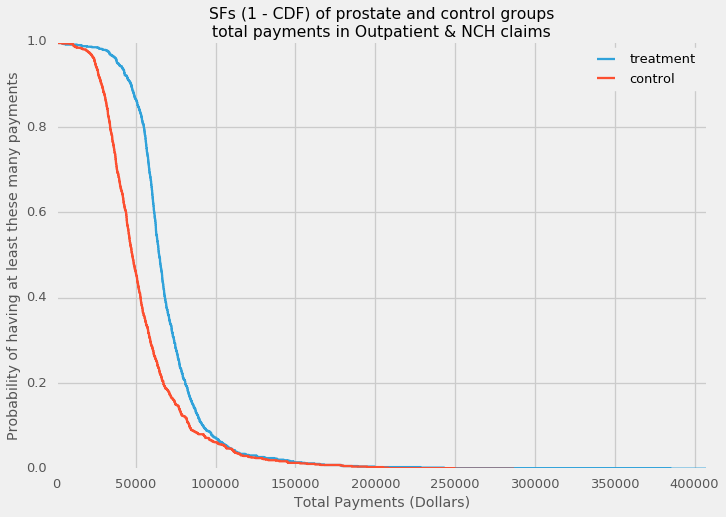

In [441]:
at = 1 -treatmentoutpatientnch['total'].value_counts(normalize=True).sort_index().cumsum()
ac = 1 -controloutpatientnch['total'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.xlabel("Total Payments (Dollars)")
plt.ylabel("Probability of having at least these many payments")
plt.title('SFs (1 - CDF) of prostate and control groups\ntotal payments in Outpatient & NCH claims')

In [442]:
len(treatmentoutpatientnch.index)

806

In [443]:
len(controloutpatientnch.index)

806

In [444]:
len(goodcontrolindices)

806

# <font color="#E56717">Validate that all the matched pairs are there (d_t_c keys and values), then do a paired test to quantify the difference</font>

In [448]:
len(set(d_t_c.keys()).intersection(set(treatmentoutpatientnch.index)))

806

In [449]:
len(set(d_t_c.values()).intersection(set(controloutpatientnch.index)))

806

In [450]:
treatmentoutpatientnch[['total']].head()

,total
0230482051,64205.24
0231464080,98277.35
0247481030,130400.91
0266443090,67301.07
0268487040,56627.35


In [451]:
controloutpatientnch[['total']].head()

,total
0238421020,31974.44
0240429030,57860.86
0256490040,33940.17
0274484060,62126.67
0275493070,49482.08


In [452]:
d_t_c['0230482051']

'4484106095'

In [467]:
from collections import OrderedDict
treatmentoutpatientnch_dict = OrderedDict()
for i in range(len(list(d_t_c.keys()))):
    treatmentoutpatientnch_dict[list(d_t_c.keys())[i]] = treatmentoutpatientnch['total'].loc[list(d_t_c.keys())[i]]

In [468]:
from collections import OrderedDict
controloutpatientnch_dict = OrderedDict()
for i in range(len(list(d_t_c.values()))):
    controloutpatientnch_dict[list(d_t_c.values())[i]] = controloutpatientnch['total'].loc[list(d_t_c.values())[i]]

In [470]:
# treatmentoutpatientnch_dict

In [471]:
q = list(treatmentoutpatientnch_dict.items())

treatmentvals = [q[p][1] for p in range(len(list(treatmentoutpatientnch_dict.items())))]

treatmentindex = [q[p][0] for p in range(len(list(treatmentoutpatientnch_dict.items())))]

In [472]:
q = list(controloutpatientnch_dict.items())

controlvals = [q[p][1] for p in range(len(list(controloutpatientnch_dict.items())))]

controlindex = [q[p][0] for p in range(len(list(controloutpatientnch_dict.items())))]

In [473]:
dfoutpatientnch = pd.DataFrame({'control_vals': controlvals,
                               'control_ids': controlindex,
                               'treatment_vals': treatmentvals,
                               'treatment_ids': treatmentindex})

In [474]:
dfoutpatientnch.head()

,control_ids,control_vals,treatment_ids,treatment_vals
0,2117163080,29073.53,2136138000,53526.38
1,8884013323,54468.19,8807011460,56940.13
2,4402113055,57555.47,8739090580,55684.74
3,8868045400,39100.36,8859092373,49318.30
4,8898081362,81276.74,8871043352,60284.97


In [475]:
d_t_c['2136138000']

'2117163080'

In [476]:
d_t_c['8807011460']

'8884013323'

(0, 150000)

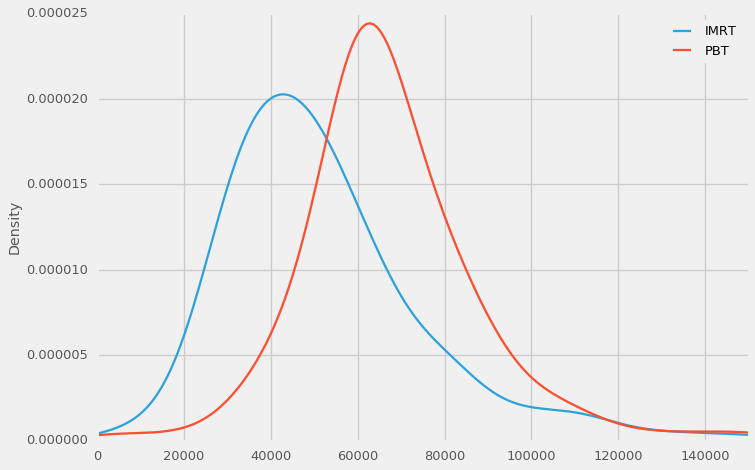

In [479]:
ax = dfoutpatientnch.control_vals.plot(kind='kde',label='IMRT')
dfoutpatientnch.treatment_vals.plot(kind='kde',ax=ax,label='PBT')
plt.legend()
plt.xlim(0,150000)

# <font color="#E56717">The above KDE plots look pretty gaussian; can use paired t-test as well as wilcoxon test</font>

In [480]:
from scipy.stats import ranksums, wilcoxon

t, p = wilcoxon(dfoutpatientnch.control_vals.as_matrix(),
               dfoutpatientnch.treatment_vals.as_matrix())

print(t,p)

74679.0 2.33660020144e-40


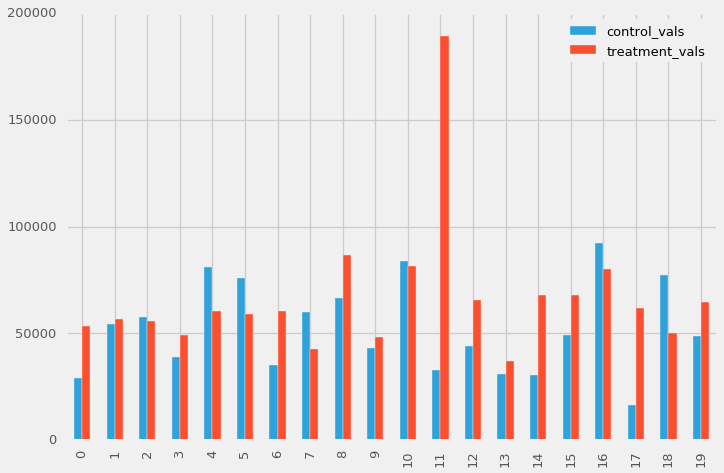

In [483]:
dfoutpatientnch[['control_vals','treatment_vals']].iloc[:20].plot(kind='bar')

In [484]:
from scipy.stats import ttest_ind

t, p = ttest_ind(dfoutpatientnch.control_vals.as_matrix(),
               dfoutpatientnch.treatment_vals.as_matrix())

print(t,p)

-10.7254395919 5.69183214427e-26


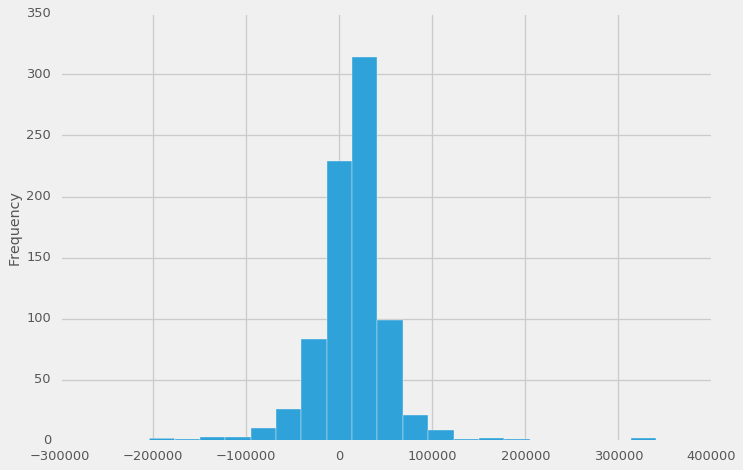

In [486]:
dfoutpatientnch['diff'] = dfoutpatientnch.treatment_vals - dfoutpatientnch.control_vals
dfoutpatientnch['diff'].plot(kind='hist',bins=20)

In [487]:
from scipy.stats import ttest_rel

t, p = ttest_rel(dfoutpatientnch.control_vals.as_matrix(),
               dfoutpatientnch.treatment_vals.as_matrix())

print(t,p)

-11.0871942443 1.10441164988e-26


In [488]:
dfoutpatientnch['diff'].describe()

count       806.000000
mean      15440.594069
std       39537.560565
min     -204116.580000
25%       -2329.395000
50%       18521.225000
75%       33264.332500
max      340726.910000
Name: diff, dtype: float64

# <font color="#E56717">So for this group of patients, PBT cost an average of 15K more than IMRT; that's the cost of the better survival prognosis</font>

# <font color="#E56717">Need to include the MedPAR costs as well and redo the above analysis</font>

In [490]:
import pygame